In [1]:
## Load packages
library(stringr)
library(readxl)
library(rentrez)
library(Biostrings)
library(dplyr)
library(tidyr)
library(jsonlite)
library(ggplot2)
library(viridis)
library(gggenes)
library(sf)
library(spData)
library(maps)
library(mapproj)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: XVector

Loading required package: GenomeInfoDb


Attachin

In [2]:
## Adjust PATH
wd <- getwd()
subdir <- "/bin" # should be 'scripts' if location is ./scripts/thisfile
if (endsWith(wd, subdir)) {
    wd <- str_remove(wd, subdir)
    setwd(wd)
}
getwd()

[1] "/home/dieol22p/arabinosylation-anti-CRISPR"

In [3]:
## Define variables
path <- "data/phages/"

genomes <- list(
    overview = "overview.csv",
    annotation = "annotation.gtf",
    archive = "genomes/ncbi_dataset/data/"
)
for (i in names(genomes)) {genomes[[i]] <- paste0(path, genomes[[i]])}

ncbi <- list()
for (i in list.files(genomes$archive)) {
    j <- str_split(i, "\\.")[[1]][1]
    ncbi[[j]] <- paste0(genomes$archive, i)
}
ncbi

$annotation_report
[1] "data/phages/genomes/ncbi_dataset/data/annotation_report.jsonl"

$biosample_report
[1] "data/phages/genomes/ncbi_dataset/data/biosample_report.jsonl"

$cds
[1] "data/phages/genomes/ncbi_dataset/data/cds.fna"

$data_report
[1] "data/phages/genomes/ncbi_dataset/data/data_report.jsonl"

$dataset_catalog
[1] "data/phages/genomes/ncbi_dataset/data/dataset_catalog.json"

$genomic
[1] "data/phages/genomes/ncbi_dataset/data/genomic.fna"

$protein
[1] "data/phages/genomes/ncbi_dataset/data/protein.faa"

$virus_dataset
[1] "data/phages/genomes/ncbi_dataset/data/virus_dataset.md"

In [4]:
# Colors
cols <- list(
    annotation = c(
        "Structural"="indianred",
        "Lysin"="darkorange",
        "Tape measure"="seagreen3",
        "Enzyme"="cyan4",
        "Immune system"="deeppink",
        'Regulatory'='cadetblue1',
        "Hypothetical"="grey30",
        "Unknown"="white"
  ),
    old_annotation = c(
        "Tail"="indianred",
        "TAC"="hotpink",
        "Lysin"="darkorange",
        "Capsid"="cyan3",
        "Tape measure"="seagreen3",
        "Collar"="deeppink",
        "Enzyme"="wheat",
        "Immune System"="navy",
        "Replication machinery"="white",
        'Transcription factor'='black',
        "Hypothetical"="grey30",
        "Other"="grey"
  ),
    rbp_type = c(
        "RBP"="indianred",
        "Adhesin"="darkorange",
        "Dit"="navy",
        "Putative RBP"="purple",
        "None"="grey"
    )
)

In [5]:
## Read data
report <- read.csv(genomes$overview)
gtf <- read.delim(genomes$annotation, sep = "\t", header = TRUE, stringsAsFactors = FALSE)
ann <- read_excel("docs/supplementary-tables.xlsx", "proteins")

In [6]:
# Modify report ---------------------------------------------------

## Genus
report$Genus <- as.character(report$virusGenus)
df <- as.data.frame(table(report$Genus))
report$Genus[is.na(report$Genus)] <- "Other"
index <- report$Genus %in% as.character(df[[1]][df[[2]] <=3])
report$Genus[index] <- "Other"

### Genus size
report$N <- 1
report <- report %>% group_by(Genus) %>% mutate(Count = sum(N))
report$Genus <- reorder(report$Genus, report$Count, decreasing=TRUE)
index <- which(levels(report$Genus)=="Other")
report$Genus <- factor(report$Genus, c(levels(report$Genus)[-index], "Other"))

# Modify GTF --------------------------------------------------

## Annotation
index <- match(gtf$Gene.CDS.Protein.FASTA.Accession, ann$protein_accession)
gtf$annotation <- ann$name[index]

## Start - stop
gtf <- mutate(gtf, gene_start=Gene.CDS.Nucleotide.FASTA.Range.Start, gene_stop = Gene.CDS.Nucleotide.FASTA.Range.Stop)

## Subset
gtf <- subset(gtf, Accession %in% report$accession)
gtf <- subset(gtf, !is.na(gene_start))

# Create combined data.frame  --------------------------------------------------
data <- merge(gtf, report, by.x = 'Accession', by.y = 'accession')
data$phage_id <- paste0(data$virusName,'_', data$Accession)

## Create relative genome coordinates
data <- data %>% group_by(phage_id) %>% 
    mutate(total=max(gene_stop, na.rm = TRUE), ratio_start=gene_start/total, ratio_stop=gene_stop/total)

In [7]:
table(ann$protein_accession %in% gtf$Gene.CDS.Protein.FASTA.Accession)
dim(ann)
dim(gtf)


FALSE  TRUE 
  185    38 

[1] 223   5

[1] 8694   12

In [8]:
# Check which organisms are not in the selection
x <- unique(ann$organism) %in% report$virusName
unique(ann$organism)[!x]

[1] "Achromobacter phage 83-24"             
 [2] "Achromobacter phage JWX"               
 [3] "Aeromonas phage 25"                    
 [4] "Aeromonas phage 44RR2.8t"              
 [5] "Alphaproteobacteria phage PhiJL001"    
 [6] "Bacillus phage CP-51"                  
 [7] "Bacillus phage G"                      
 [8] "Bacillus phage SP-10"                  
 [9] "Bacillus phage SPO1"                   
[10] "Citrobacter phage Merlin"              
[11] "Delftia phage PhiW-14"                 
[12] "Dickeya phage vB-DsoM-LIMEstone1"      
[13] "E. coli ThyA"                          
[14] "Enterobacter phage CC31"               
[15] "Escherichia phage Bas46"               
[16] "Escherichia phage Bas47"               
[17] "Escherichia phage T5"                  
[18] "Escherichia phage wV7"                 
[19] "Pectobacterium bacteriophage PM2"      
[20] "Pseudomonas phage M6"                  
[21] "Pseudomonas phage MP1412"              
[22] "Ralstonia phage phiRSL1"               
[23] "Rhodoferax phage P26218"               
[24] "Roseobacter phage RDJL Phi 1"          
[25] "Salmonella phage vB_SenM-S16"          
[26] "Serratia phage PS2"                    
[27] "Shigella phage pSs-1"                  
[28] "Sphingomonas phage PAU"                
[29] "Stenotrophomonas phage IME13"          
[30] "Xanthomonas phage Xp15"                
[31] "Yersinia phage PST"                    
[32] "Acinetobacter phage AB-Navy1"          
[33] "Acinetobacter phage AB-Navy71"         
[34] "Acinetobacter phage AB-Navy97"         
[35] "Acinetobacter phage AbTZA1"            
[36] "Acinetobacter phage AC4"               
[37] "Acinetobacter phage Acj9"              
[38] "Acinetobacter phage KARL-1"            
[39] "Acinetobacter phage MD-2021a"          
[40] "Acinetobacter phage Meroveus"          
[41] "Acinetobacter phage PhaR5"             
[42] "Acinetobacter phage vB_AbaM_AB-Navy-v2"
[43] "Acinetobacter phage vB_AbaM_Apostate"  
[44] "Acinetobacter phage vB_AbaM_Berthold"  
[45] "Acinetobacter phage vB_AbaM_DLP1"      
[46] "Acinetobacter phage vB_AbaM_DLP2"      
[47] "Acinetobacter phage vB_AbaM_DP45"      
[48] "Acinetobacter phage vB_AbaM_Kimel"     
[49] "Acinetobacter phage vB_AbaM_Konradin"  
[50] "Acinetobacter phage vB_AbaM_Lazarus"   
[51] "Acinetobacter phage vB_AbaM_PhT2"      
[52] "Acinetobacter phage vB_AbaM_Porter"    
[53] "Acinetobacter phage vB_ApiM_fHyAci03"  
[54] "Enterobacteria phage ATK47"            
[55] "Escherichia phage a20"                 
[56] "Escherichia phage AV109"               
[57] "Escherichia phage AV110"               
[58] "Escherichia phage AV111"               
[59] "Escherichia phage AV117"               
[60] "Escherichia phage AV118"               
[61] "Escherichia phage ECCR664"             
[62] "Escherichia phage F2"                  
[63] "Escherichia phage FL18"                
[64] "Escherichia phage JM17"                
[65] "Escherichia phage JN02"                
[66] "Escherichia phage LH01"                
[67] "Escherichia phage moskry"              
[68] "Escherichia phage OLB35"               
[69] "Escherichia phage p000y"               
[70] "Escherichia phage PHB12"               
[71] "Escherichia phage phiE142"             
[72] "Escherichia phage PNJ-6"               
[73] "Escherichia phage PTK"                 
[74] "Escherichia phage ST0"                 
[75] "Escherichia phage vB_Eco_F27"          
[76] "Escherichia phage vB_Eco_F31"          
[77] "Escherichia phage vB_Eco_NicPhage"     
[78] "Escherichia phage vB_EcoM_EP32a"       
[79] "Escherichia phage vB_EcoM_ESCO47"      
[80] "Escherichia phage vB_EcoM_G2285"       
[81] "Escherichia phage vB_EcoM_G2469"       
[82] "Escherichia phage vB_EcoM_G53"         
[83] "Escherichia phage vB_EcoM_JS09"        
[84] "Escherichia phage vB_EcoM_KAW3E185"    
[85] "Escherichia phage vB_EcoM_MM02"        
[86] "Escherichia phage vB_EcoM_NBG1"        
[87] "Escherichia phage vB_EcoM_PhAPEC2"     

In [121]:
# Search gene names
#data$Gene.CDS.Name[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'synthase')]
data$Gene.CDS.Name[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'synthase')]

[1] "dTMP (thymidylate) synthase"   "dTMP (thymidylate) synthase"  
 [3] "dTMP (thymidylate) synthase"   "dTMP (thymidylate) synthase"  
 [5] "thymidylate synthase"          "putative thymidylate synthase"
 [7] "dTMP (thymidylate) synthase"   "putative thymidylate synthase"
 [9] "putative thymidylate synthase" "putative thymidylate synthase"
[11] "putative thymidylate synthase" "thymidylate synthase"         
[13] "(thymidylate) synthase"        "thymidylate synthase"         
[15] "putative thymidylate synthase" "thymidylate synthase"         
[17] "thymidylate synthase"          "thymidylate synthase"         
[19] "thymidylate synthase"          "thymidylate synthase"         
[21] "thymidylate synthase"          "thymidylate synthase"         
[23] "thymidylate synthase"          "thymidylate synthase"         
[25] "putative thymidylate synthase" "thymidylate synthase"         
[27] "thymidylate synthase"          "thymidylate synthase"         
[29] "Putative thymidylate synthase" "thymidylate synthase"         
[31] "thymidylate synthase"          "thymidylate synthase"         
[33] "thymidylate synthase"          "thymidylate synthase"         
[35] "thymidylate synthase"          "thymidylate synthase"         
[37] "thymidylate synthase"          "putative thymidylate synthase"
[39] "thymidylate synthase"          "thymidylate synthase"         
[41] "thymidylate synthase"          "thymidylate synthase"         
[43] "thymidylate synthase"

In [119]:
data$Gene.CDS.Name[str_detect(data$Gene.CDS.Name, 'thymidylate')]

[1] "dTMP (thymidylate) synthase"   "dTMP (thymidylate) synthase"  
 [3] "dTMP (thymidylate) synthase"   "dTMP (thymidylate) synthase"  
 [5] "thymidylate synthase"          "putative thymidylate kinase"  
 [7] "putative thymidylate synthase" "dTMP thymidylate synthetase"  
 [9] "dTMP (thymidylate) synthase"   "putative thymidylate synthase"
[11] "putative thymidylate synthase" "putative thymidylate synthase"
[13] "putative thymidylate kinase"   "putative thymidylate synthase"
[15] "dTMP thymidylate synthetase"   "thymidylate synthase"         
[17] "(thymidylate) synthase"        "thymidylate synthetase"       
[19] "thymidylate synthase"          "putative thymidylate synthase"
[21] "thymidylate synthase"          "thymidylate synthase"         
[23] "putative thymidylate kinase"   "thymidylate synthase"         
[25] "putative thymidylate kinase"   "thymidylate kinase"           
[27] "thymidylate synthase"          "thymidylate synthase"         
[29] "thymidylate kinase"            "thymidylate kinase"           
[31] "Td thymidylate synthetase"     "thymidylate synthase"         
[33] "thymidylate synthase"          "thymidylate kinase"           
[35] "thymidylate kinase"            "thymidylate synthase"         
[37] "thymidylate synthase"          "thymidylate kinase"           
[39] "putative thymidylate synthase" "thymidylate synthase"         
[41] "thymidylate kinase"            "thymidylate synthase"         
[43] "dTMP thymidylate synthetase"   "thymidylate kinase"           
[45] "thymidylate synthase"          "thymidylate kinase"           
[47] "Putative thymidylate synthase" "thymidylate synthase"         
[49] "thymidylate synthase"          "thymidylate kinase"           
[51] "thymidylate synthase"          "thymidylate kinase"           
[53] "thymidylate synthase"          "thymidylate kinase"           
[55] "thymidylate synthase"          "thymidylate synthase"         
[57] "thymidylate synthase"          "thymidylate synthase"         
[59] "putative thymidylate synthase" "thymidylate synthase"         
[61] "thymidylate synthase"          "thymidylate kinase"           
[63] "thymidylate synthase"          "thymidylate kinase"           
[65] "thymidylate synthase"          "thymidylate synthase"

In [126]:
# Annotation

# Transfer into new vector
data$ann_level_1 <- data$Gene.CDS.Name
data$ann_level_1 <- 'Other'

## Hypothetical
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'hypothetical')] <- 'Hypothetical'
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'Hypothetical')] <- 'Hypothetical'
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'hypothetical')] <- 'Hypothetical'

## Structural
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'head')] <- 'Structural'
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'tail')] <- 'Structural'
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'sheath')] <- 'Structural'
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'base')] <- 'Structural'
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'capsid')] <- 'Structural'

## Essential genes
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'endonuclease')] <- 'Endonuclease'

## Step A - dCTP modification
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'dCTP') & str_detect(data$Gene.CDS.Name, 'ase')] <- 'dCTPase'
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'peptidase') & str_detect(data$Gene.CDS.Name, 'U32')] <- 'HMase'
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'dCMP') & str_detect(data$Gene.CDS.Name, 'hydroxy')] <- 'HMase'
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'dNMP kinase')] <- 'dNMP kinase'
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'DNA pol')] <- 'DNA pol'

## Step B - UTP arabinosylation
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'arabinose') & str_detect(data$Gene.CDS.Name, 'isomerase')] <- 'Isomerase'
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'phosphoheptose') & str_detect(data$Gene.CDS.Name, 'isomerase')] <- 'Isomerase'
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'NTP') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'NTP transfer'

## Step C - Glucosylation
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'glucos') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'Glu transfer'

## Step D - Ararbinosylation
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'ara') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'Ara transfer'
# Most Aat genes are not annotated !!!

## Step E - function?
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'synthase')] <- 'Thy syn'
data$ann_level_1[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'kinase')] <- 'Thy kin'

## Modification machinery
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'synthase')] <- 'TS'
#data$ann_level_1[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'kinase')] <- 'TK'

unique(data$ann_level_1)

[1] "Other"        "dCTPase"      "Glu transfer" "HMase"        "DNA pol"     
 [6] "dNMP kinase"  "Thy syn"      "Isomerase"    "Thy kin"      "Ara transfer"
[11] "NTP transfer"

In [127]:
# Add colors
cols$ann_level_1 <- c(
    'Other' = 'grey90',
    'TS' = 'indianred',
    'HMase' = 'darkorange',
    'Aat' = 'green',
    'DNA pol' = 'navy',
    'Ara isom.' = 'purple',
    'PH isom.' = 'skyblue',
    'NTP transf.' = 'hotpink',
    'Peptidase' = 'pink',
    'TK' = 'yellow',
    'GT' = 'cyan3'
)

cols$ann_level_1 <- c(
    'Other' = 'grey90',
    'dCTPase' = 'palegreen',
    'HMase' = 'plum',
    'dNMP kinase' = 'seagreen',
    'DNA pol' = 'darkolivegreen',
    'Isomerase' = 'navy',
    'NTP transfer' = 'cyan3',
    'Glu transfer' = 'darkorange',
    'Ara transfer' = 'indianred',
    'Thy syn' = 'purple',
    'Thy kin' = 'hotpink'
)
data$ann_level_1 <- factor(data$ann_level_1, names(cols$ann_level_1))

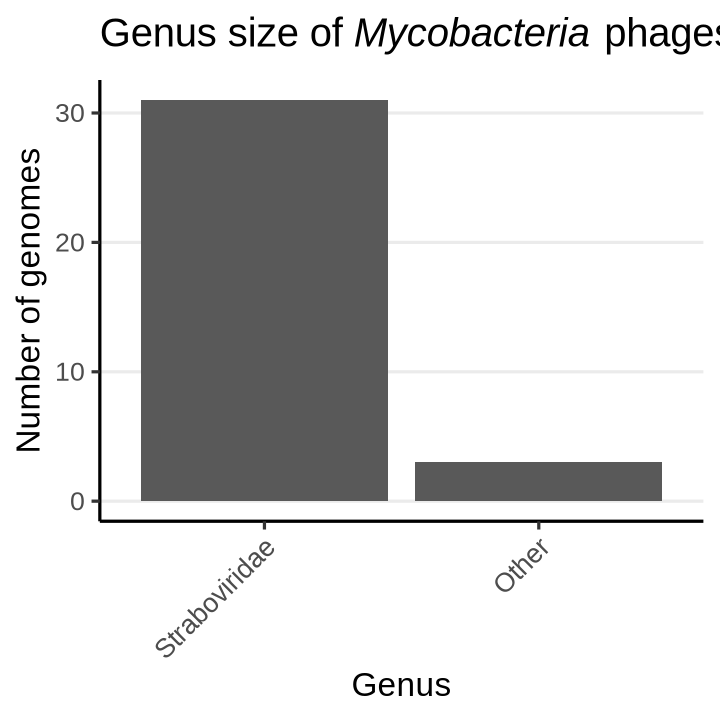

In [12]:
## Compare virus genera
options(repr.plot.width=6, repr.plot.height=6)

df <- report %>% group_by(Genus) %>% summarize(Count = sum(N))

# Plot
ggplot(df, aes(Genus, Count)) +
    geom_col() +
    theme_classic(20) +
    theme(
        axis.text.x = element_text(angle=45, hjust=1, vjust=1),
        panel.grid.major.y = element_line()
    ) +
    labs(title=substitute(paste('Genus size of ',italic('Mycobacteria'),' phages')),
        x='Genus', y='Number of genomes')

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


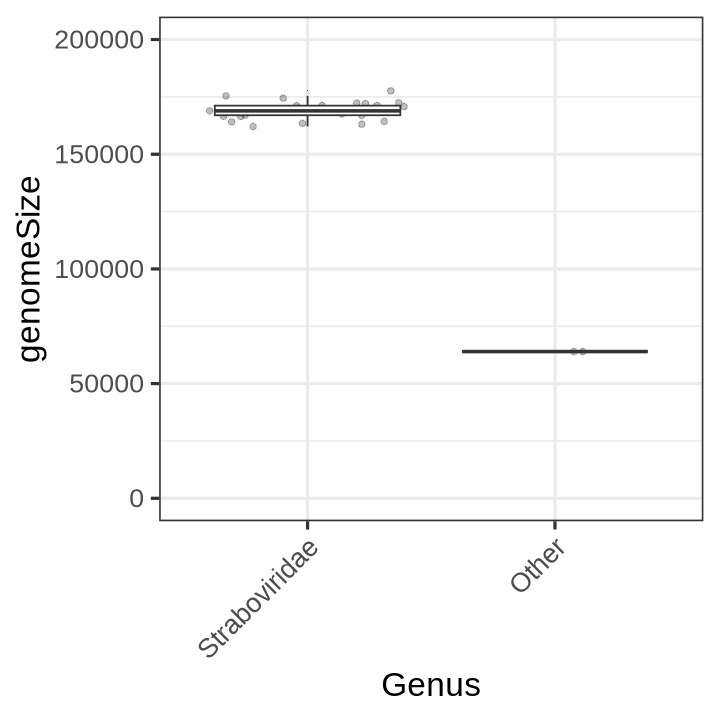

In [13]:
## Compare virus genus
options(repr.plot.width=6, repr.plot.height=6)

# Plot
ggplot(report, aes(Genus, y=genomeSize)) +
    geom_point(position="jitter", alpha=.25) +
    geom_boxplot(outlier.size = 0.01, outlier.stroke = NA) +
    theme_bw(20) +
    theme(
        axis.text.x = element_text(angle=45, hjust=1, vjust=1)
    ) +
    scale_y_continuous(limits=c(0, 200000))

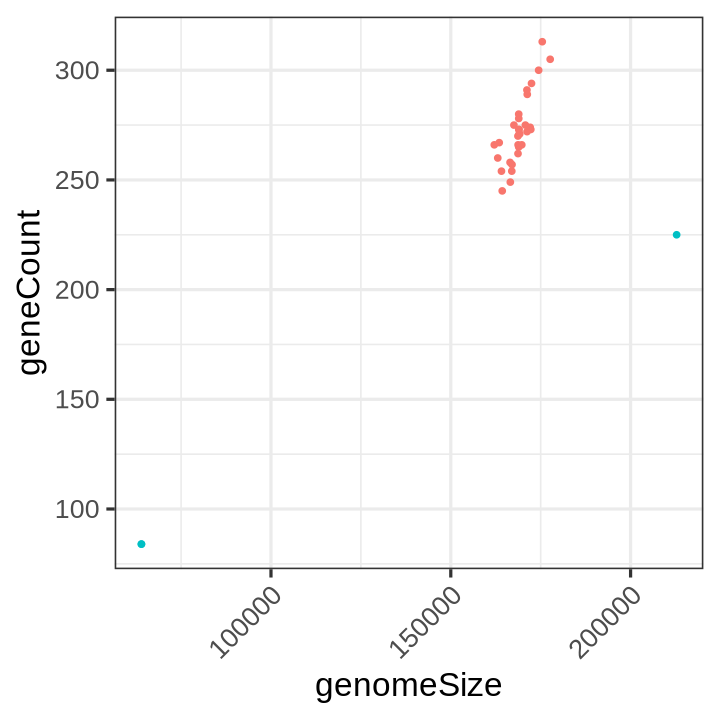

In [14]:
## Compare genomeSize and geneCount
options(repr.plot.width=6, repr.plot.height=6)

# Plot
ggplot(report, aes(x=genomeSize, y=geneCount, col=Genus)) +
    geom_point() +
    theme_bw(20) +
    theme(
        axis.text.x = element_text(angle=45, hjust=1, vjust=1)
    ) +
    guides(
        col = guide_none()
    )

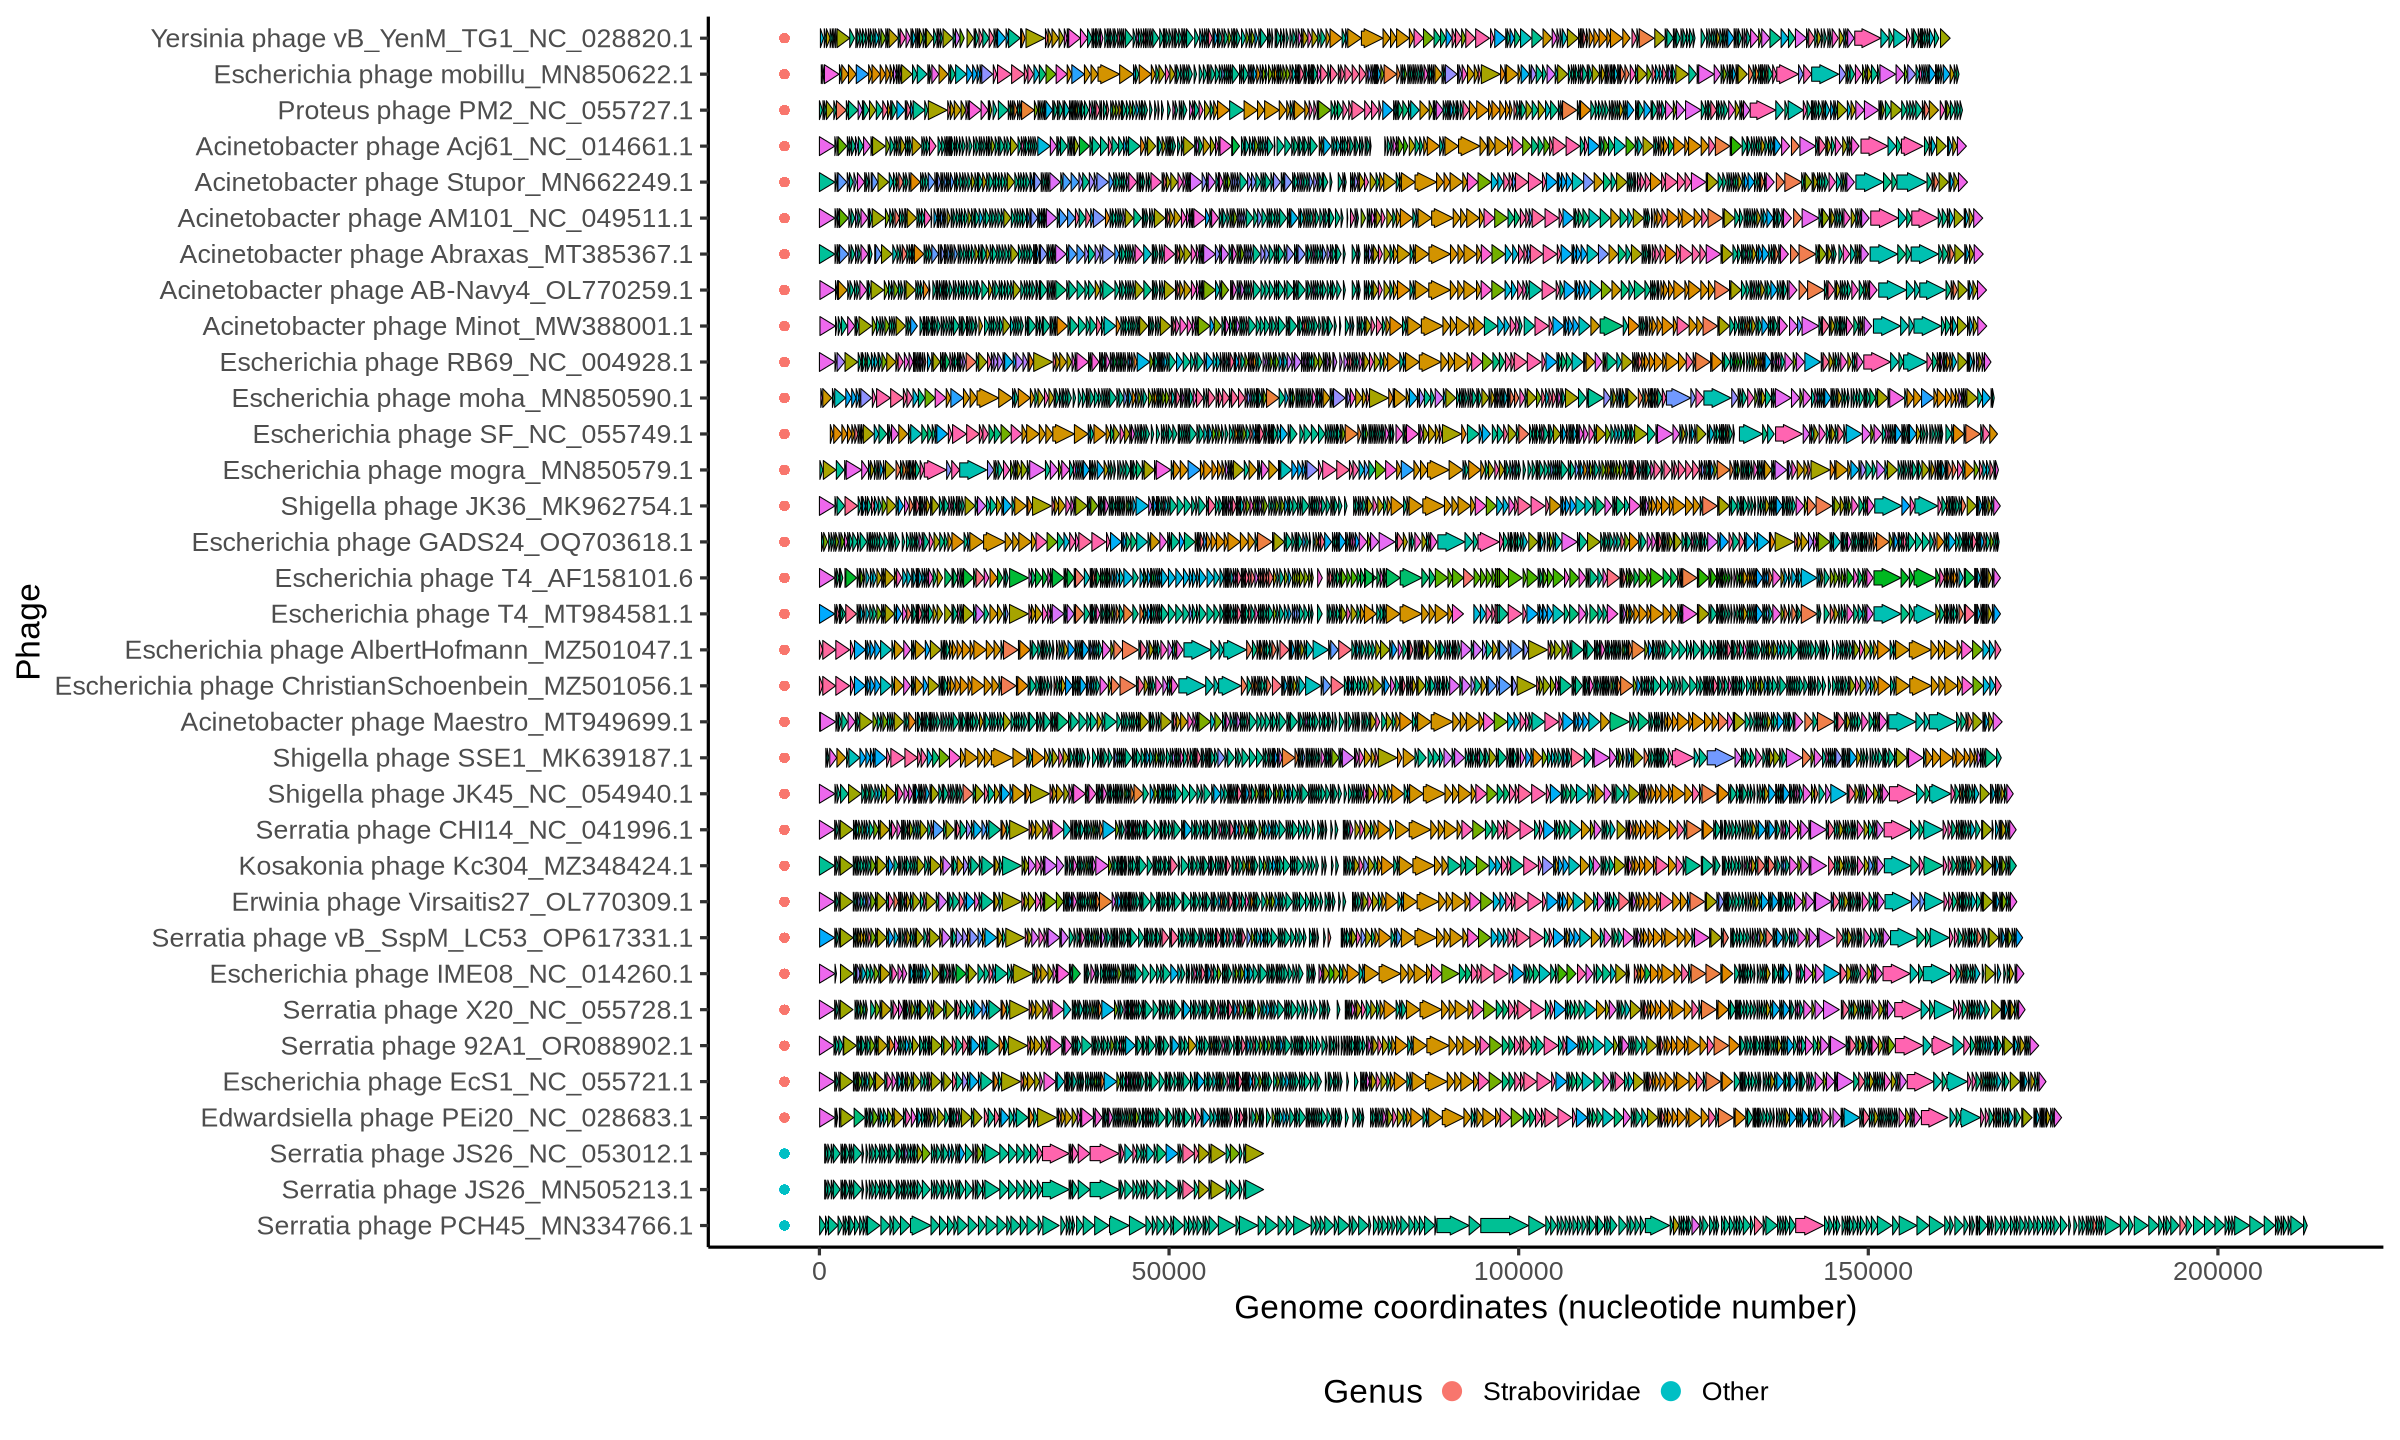

In [15]:
## Visualize genomes
options(repr.plot.width=20, repr.plot.height=12)

# Fetch data
df <- data

## Order
df <- df[order(df$Genus, df$genomeSize, decreasing = c(TRUE, TRUE)), ]
df$phage_id <- factor(df$phage_id, unique(df$phage_id))

# Plot
ggplot(df, aes(xmin = gene_start, xmax = gene_stop, y = phage_id, fill = Gene.CDS.Name)) +
    geom_gene_arrow() +
    geom_point(aes(x=-5000, col=Genus), size=2) +
    theme_classic(20) +
    guides(fill = guide_none(), 
           col = guide_legend(override.aes = list(size=5), position = 'bottom', nrow = 1)) +
    labs(x = "Genome coordinates (nucleotide number)", y = "Phage")

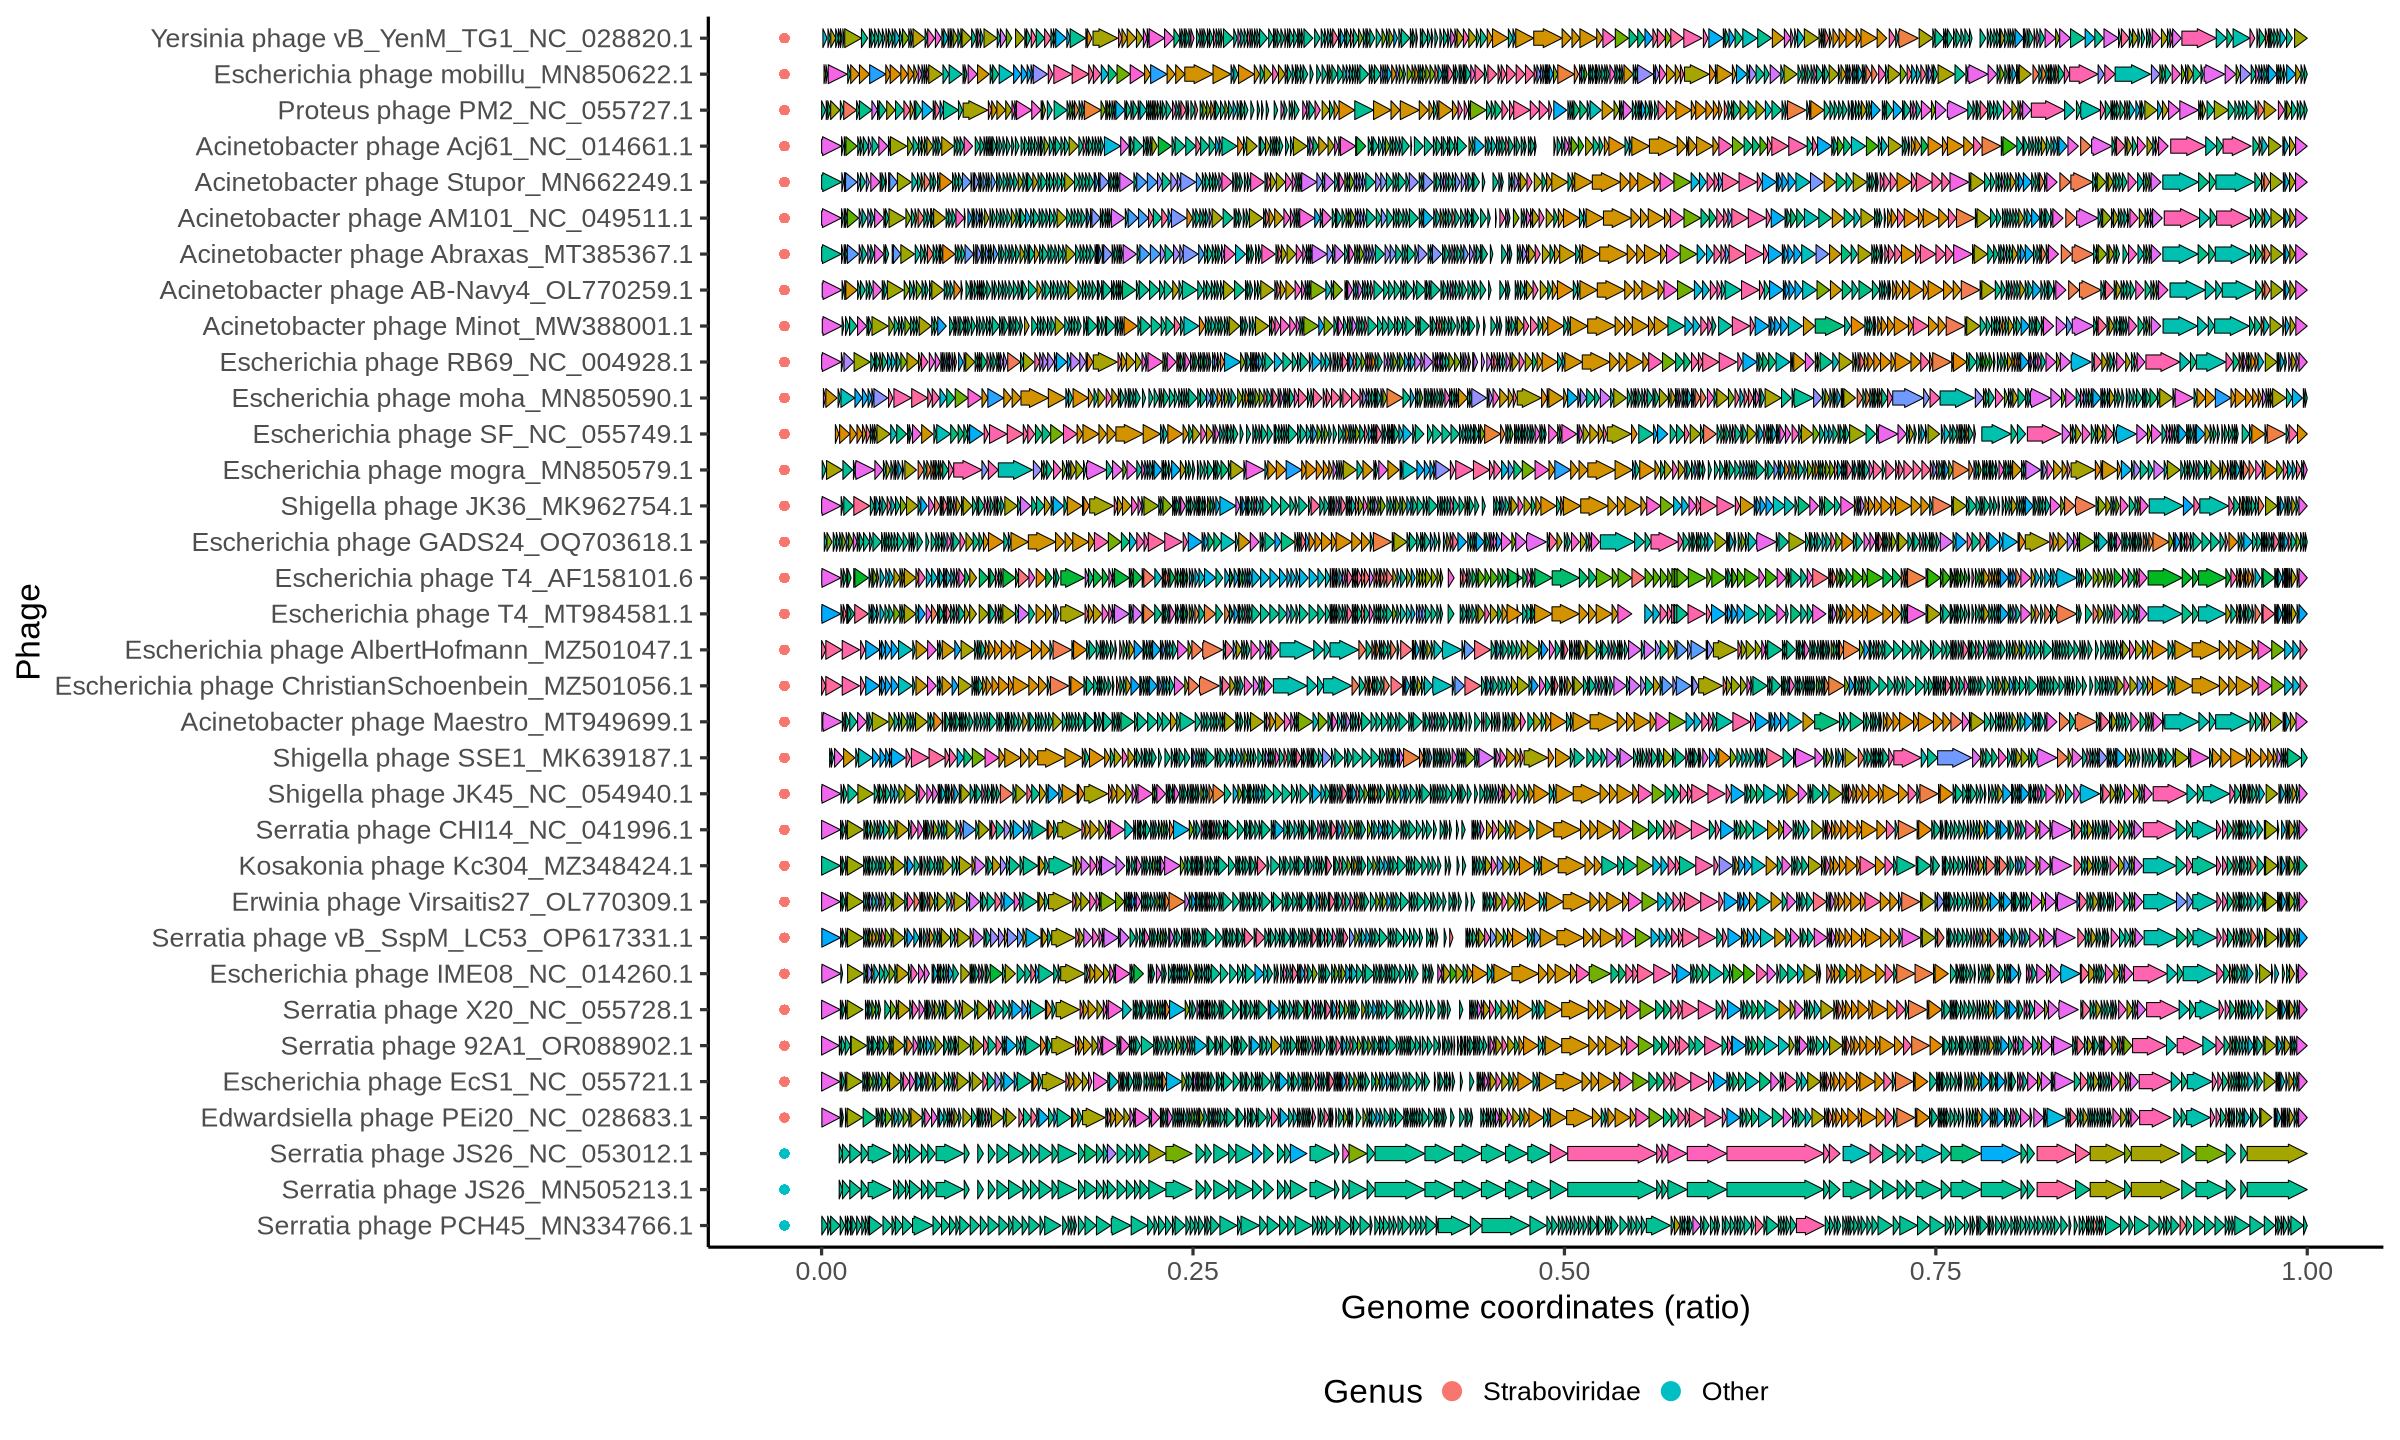

In [16]:
# Plot
ggplot(df, aes(xmin = ratio_start, xmax = ratio_stop, y = phage_id, fill = Gene.CDS.Name)) +
    geom_gene_arrow() +
    geom_point(aes(x=-0.025, col=Genus), size=2) +
    theme_classic(20) +
    guides(fill = guide_none(), 
           col = guide_legend(override.aes = list(size=5), position = 'bottom', nrow = 1)) +
    labs(x = "Genome coordinates (ratio)", y = "Phage")

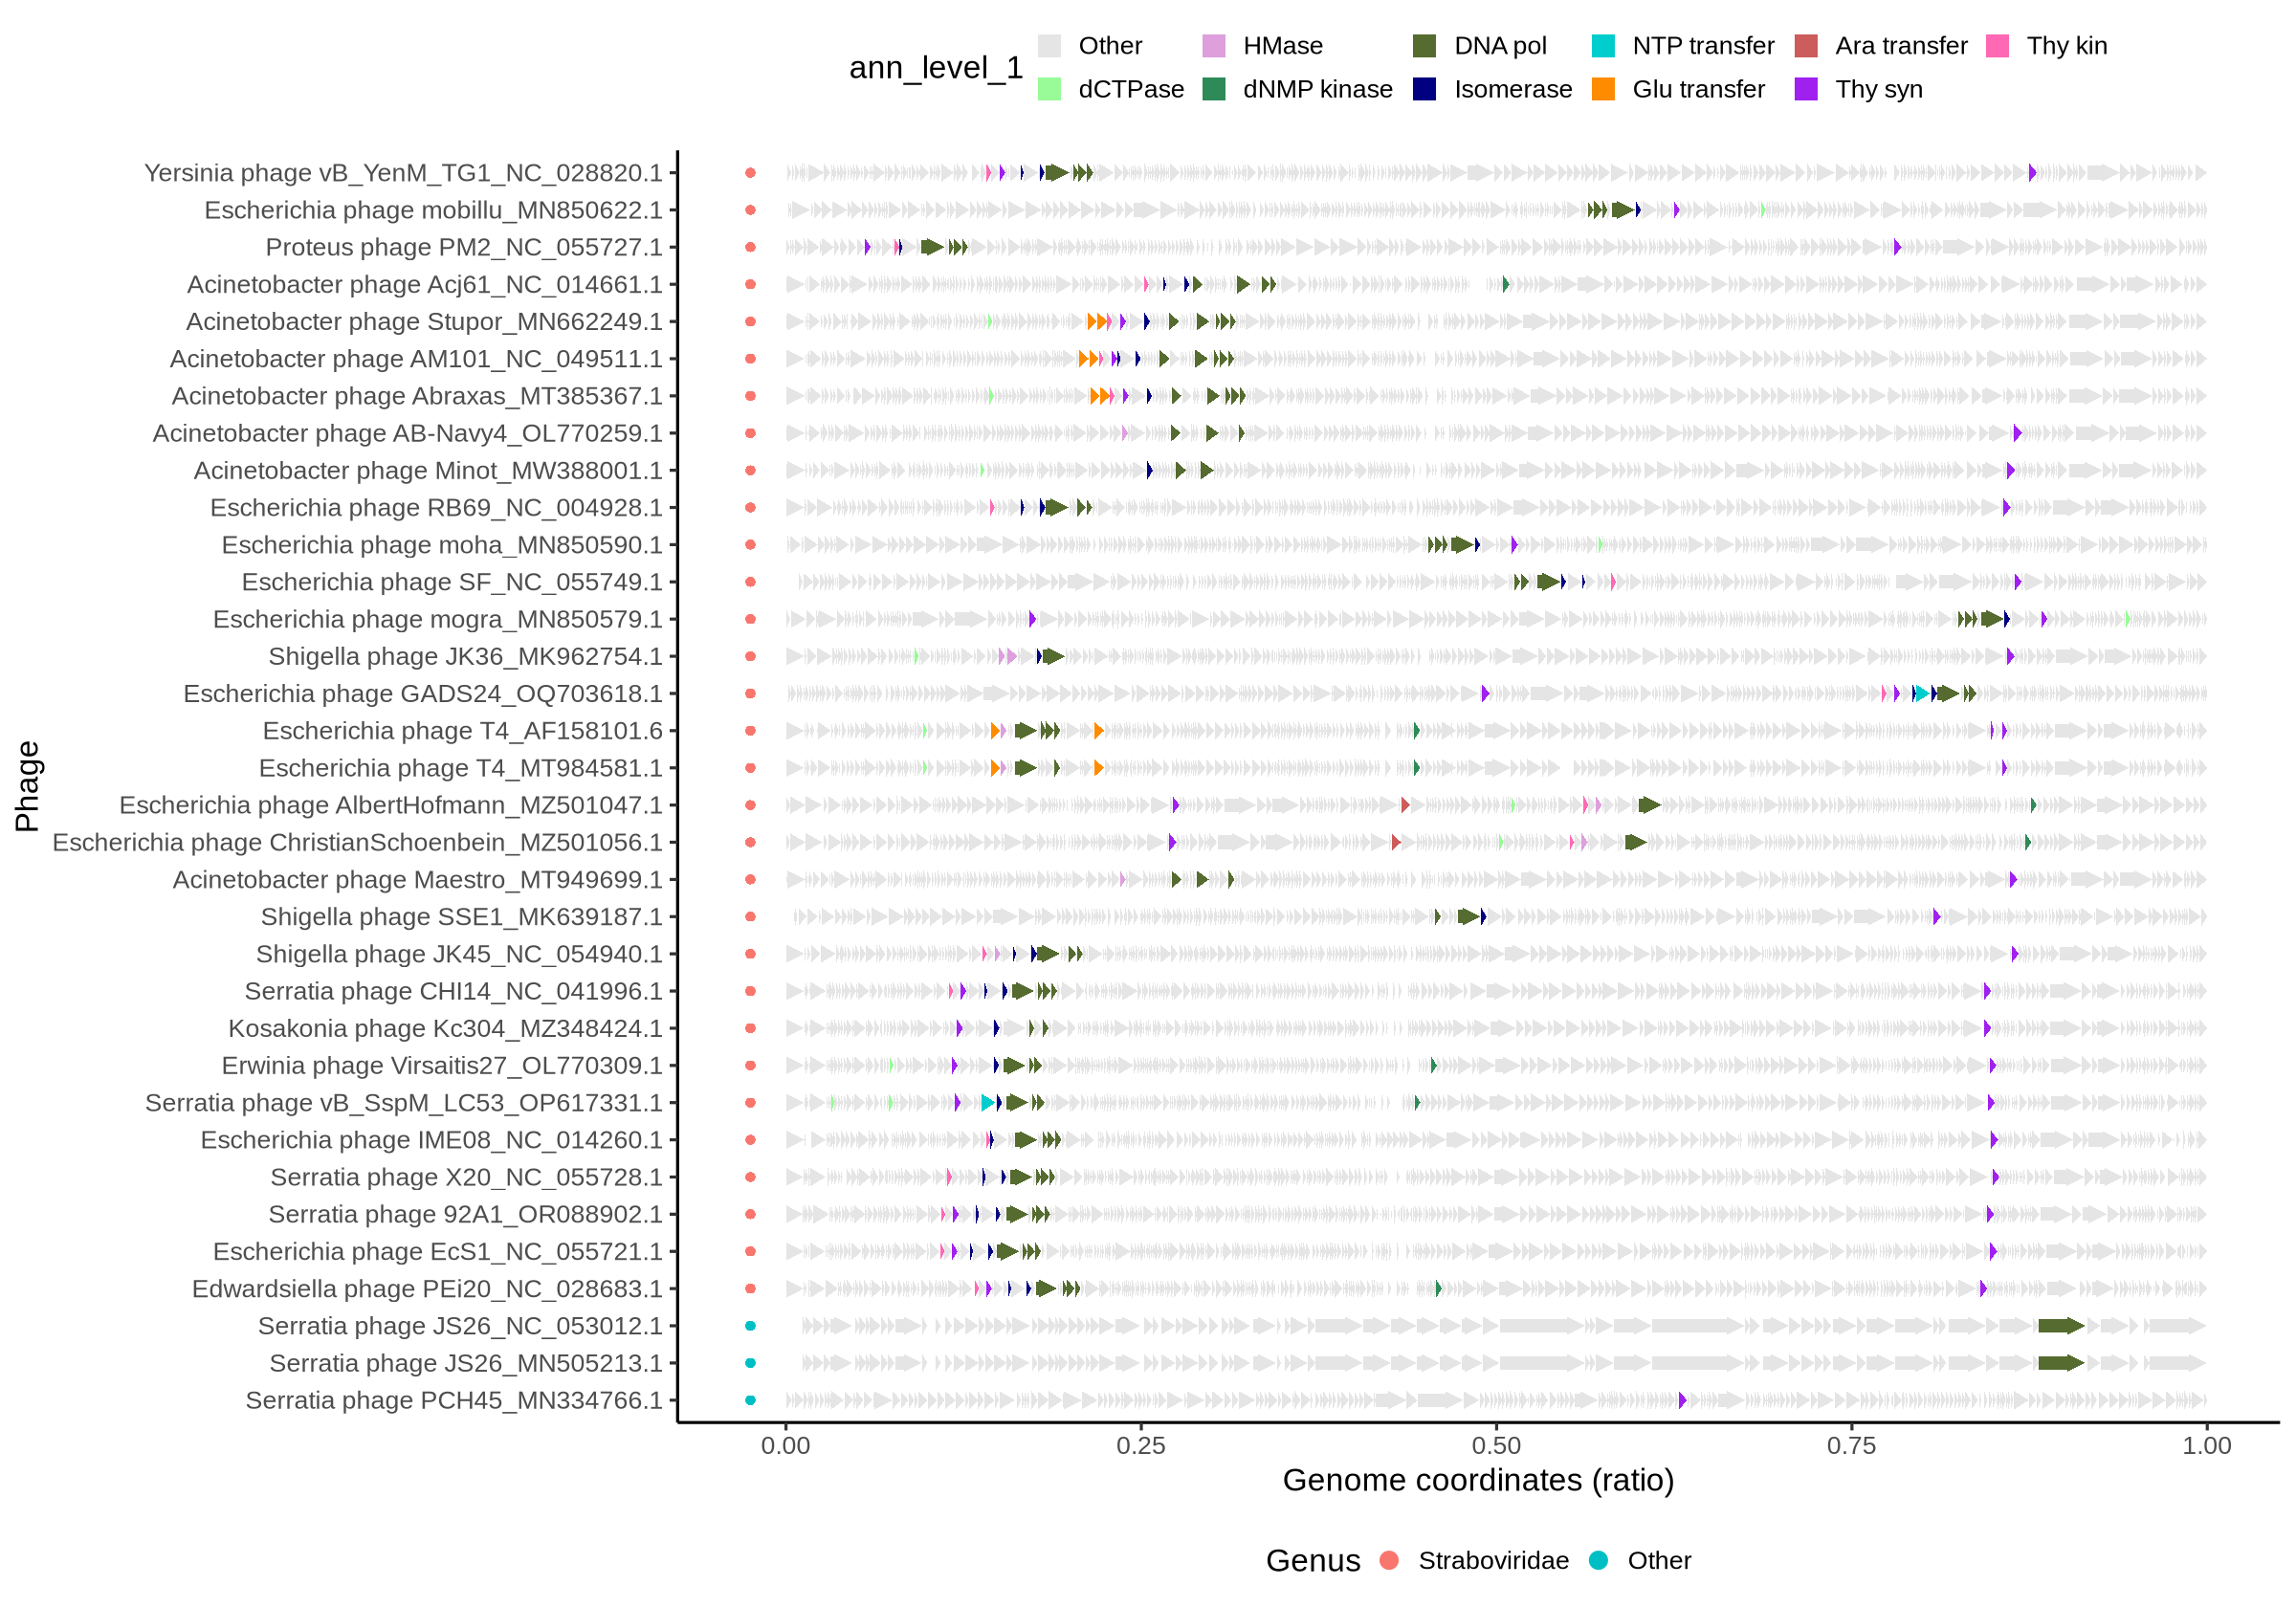

In [128]:
## Whole selection
options(repr.plot.width=20, repr.plot.height=14)

# Fetch data
set.seed(42) # change seed for different result
df <- data
df <- df[order(df$Genus, df$genomeSize, decreasing = c(TRUE, TRUE)), ]
df$phage_id <- factor(df$phage_id, unique(df$phage_id))

# Mutate
df <- df %>% group_by(phage_id) %>% mutate(total=max(gene_stop, na.rm = TRUE), ratio_start=gene_start/total, ratio_stop=gene_stop/total)

# Plot
ggplot(df, aes(xmin = ratio_start, xmax = ratio_stop, y = phage_id, fill = ann_level_1)) +
    geom_gene_arrow(col=NA) +
    geom_point(aes(x=-0.025, col=Genus), size=2) +
    scale_fill_manual(values = cols$ann_level_1) +
    theme_classic(20) +
    guides(fill = guide_legend(override.aes = list(size=0, stroke=0), position = 'top', nrow = 2), 
           col = guide_legend(override.aes = list(size=5), position = 'bottom', nrow = 1)) +
    labs(x = "Genome coordinates (ratio)", y = "Phage")

Warning message:
“Removed 7364 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”
Warning message:
“Removed 8694 rows containing missing values or values outside the scale range
(`geom_point()`).”


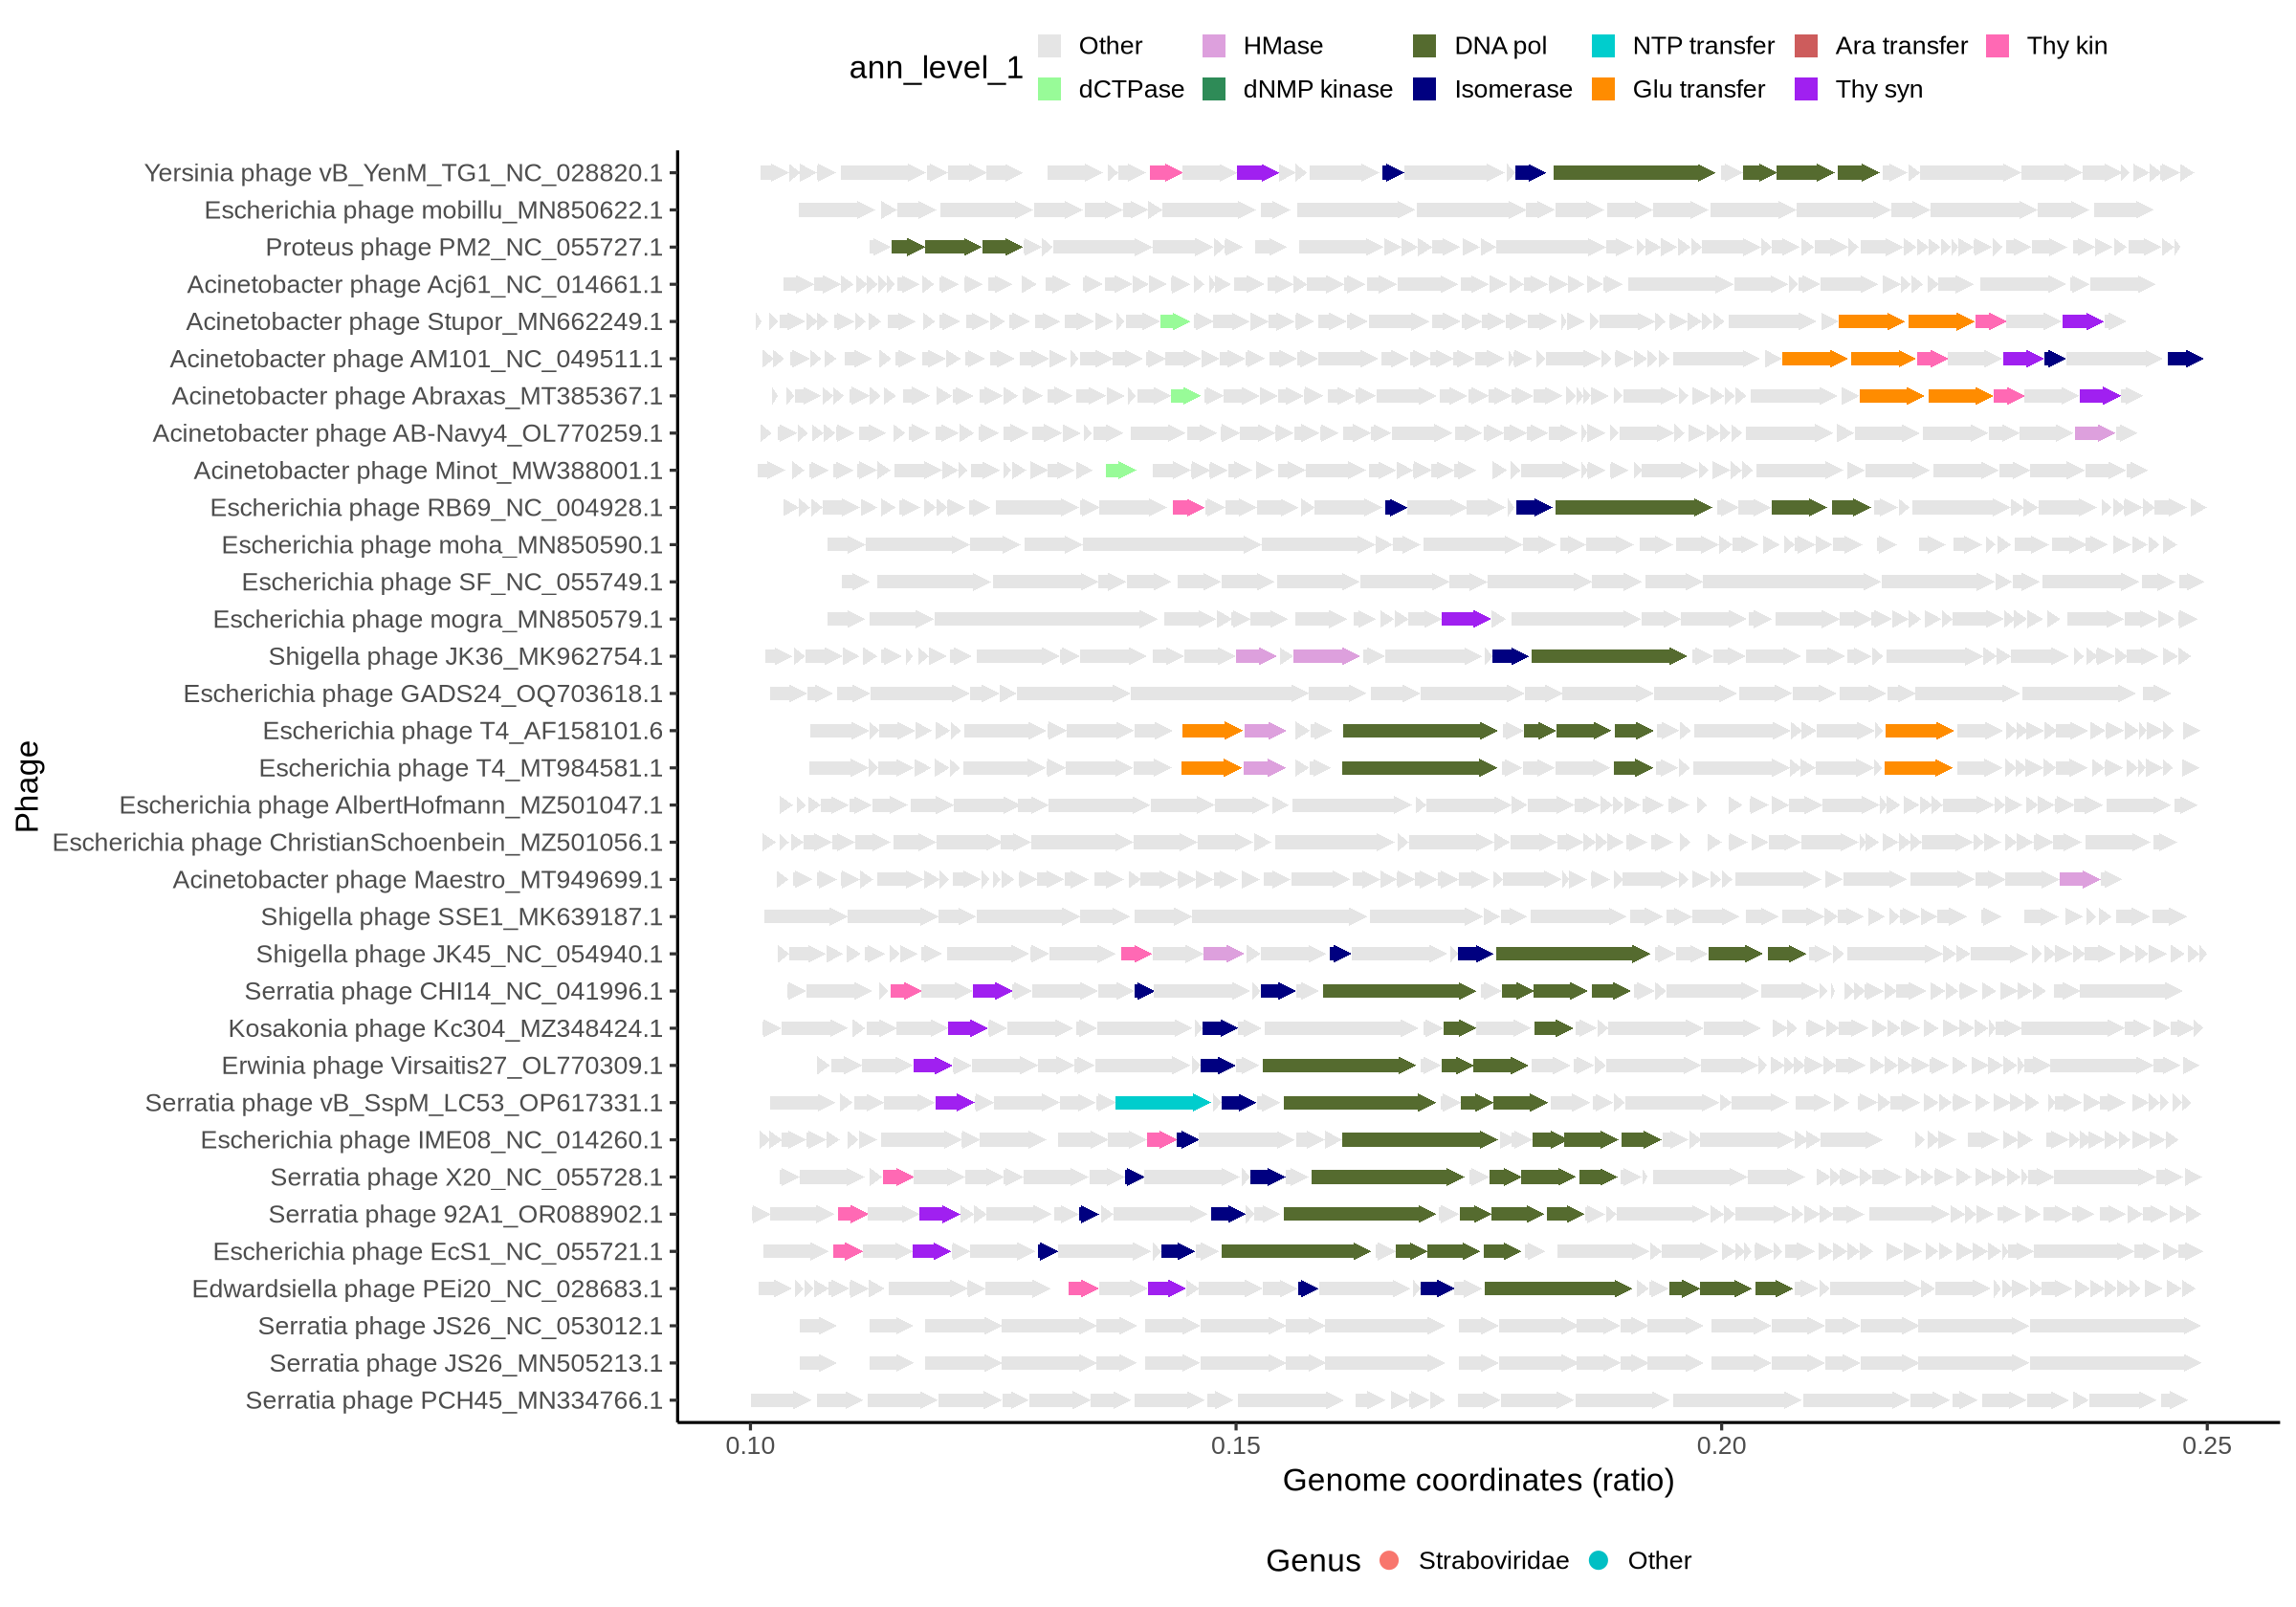

In [129]:
## Zoom
options(repr.plot.width=20, repr.plot.height=14)

# Fetch data
set.seed(42) # change seed for different result
df <- data
df <- df[order(df$Genus, df$genomeSize, decreasing = c(TRUE, TRUE)), ]
df$phage_id <- factor(df$phage_id, unique(df$phage_id))

# Mutate
df <- df %>% group_by(phage_id) %>% mutate(total=max(gene_stop, na.rm = TRUE), ratio_start=gene_start/total, ratio_stop=gene_stop/total)

# Plot
ggplot(df, aes(xmin = ratio_start, xmax = ratio_stop, y = phage_id, fill = ann_level_1)) +
    geom_gene_arrow(col=NA) +
    geom_point(aes(x=-0.025, col=Genus), size=2) +
    scale_fill_manual(values = cols$ann_level_1) +
    theme_classic(20) +
    guides(fill = guide_legend(override.aes = list(size=0, stroke=0), position = 'top', nrow = 2), 
           col = guide_legend(override.aes = list(size=5), position = 'bottom', nrow = 1)) +
    labs(x = "Genome coordinates (ratio)", y = "Phage") +
    scale_x_continuous(limits = c(0.1, 0.25))

In [108]:
# Investigate genomes locations of inidividual phages
data %>% subset(virusName == 'Serratia phage CHI14' & ratio_start >= 0.13 & ratio_stop <= 0.16)

Accession   Gene.CDS.Name                  
1 NC_041996.1 putative endonuclease          
2 NC_041996.1 phosphoheptose isomerase       
3 NC_041996.1 hypothetical protein           
4 NC_041996.1 hypothetical protein           
5 NC_041996.1 arabinose 5-phosphate isomerase
6 NC_041996.1 hypothetical protein           
  Gene.CDS.Nucleotide.FASTA.Title                                
1 putative endonuclease [organism=Serratia phage CHI14]          
2 phosphoheptose isomerase [organism=Serratia phage CHI14]       
3 hypothetical protein [organism=Serratia phage CHI14]           
4 hypothetical protein [organism=Serratia phage CHI14]           
5 arabinose 5-phosphate isomerase [organism=Serratia phage CHI14]
6 hypothetical protein [organism=Serratia phage CHI14]           
  Gene.CDS.Nucleotide.FASTA.Sequence.ID Gene.CDS.Nucleotide.FASTA.Range.Start
1 NC_041996.1:23246-23884               23246                                
2 NC_041996.1:23881-24246               23881                                
3 NC_041996.1:24230-25924               24230                                
4 NC_041996.1:25963-26106               25963                                
5 NC_041996.1:26103-26732               26103                                
6 NC_041996.1:26729-27142               26729                                
  Gene.CDS.Nucleotide.FASTA.Range.Stop Gene.CDS.Protein.FASTA.Accession
1 23884                                YP_009609366.1                  
2 24246                                YP_009609367.1                  
3 25924                                YP_009609368.1                  
4 26106                                YP_009609369.1                  
5 26732                                YP_009609370.1                  
6 27142                                YP_009609371.1                  
  Gene.CDS.Protein.FASTA.Sequence.ID
1 YP_009609366.1:1-212              
2 YP_009609367.1:1-121              
3 YP_009609368.1:1-564              
4 YP_009609369.1:1-47               
5 YP_009609370.1:1-209              
6 YP_009609371.1:1-137              
  Gene.CDS.Protein.FASTA.Title                                    annotation ⋯
1 putative endonuclease [organism=Serratia phage CHI14]           NA         ⋯
2 phosphoheptose isomerase [organism=Serratia phage CHI14]        NA         ⋯
3 hypothetical protein [organism=Serratia phage CHI14]            NA         ⋯
4 hypothetical protein [organism=Serratia phage CHI14]            NA         ⋯
5 arabinose 5-phosphate isomerase [organism=Serratia phage CHI14] NA         ⋯
6 hypothetical protein [organism=Serratia phage CHI14]            NA         ⋯
  genomeIndex Genus         N Count geoCountry    
1 22          Straboviridae 1 31    United Kingdom
2 22          Straboviridae 1 31    United Kingdom
3 22          Straboviridae 1 31    United Kingdom
4 22          Straboviridae 1 31    United Kingdom
5 22          Straboviridae 1 31    United Kingdom
6 22          Straboviridae 1 31    United Kingdom
  phage_id                         total  ratio_start ratio_stop ann_level_1
1 Serratia phage CHI14_NC_041996.1 171151 0.1358216   0.1395493  Other      
2 Serratia phage CHI14_NC_041996.1 171151 0.1395318   0.1416644  Isomerase  
3 Serratia phage CHI14_NC_041996.1 171151 0.1415709   0.1514686  Other      
4 Serratia phage CHI14_NC_041996.1 171151 0.1516965   0.1525320  Other      
5 Serratia phage CHI14_NC_041996.1 171151 0.1525144   0.1561896  Isomerase  
6 Serratia phage CHI14_NC_041996.1 171151 0.1561720   0.1585851  Other

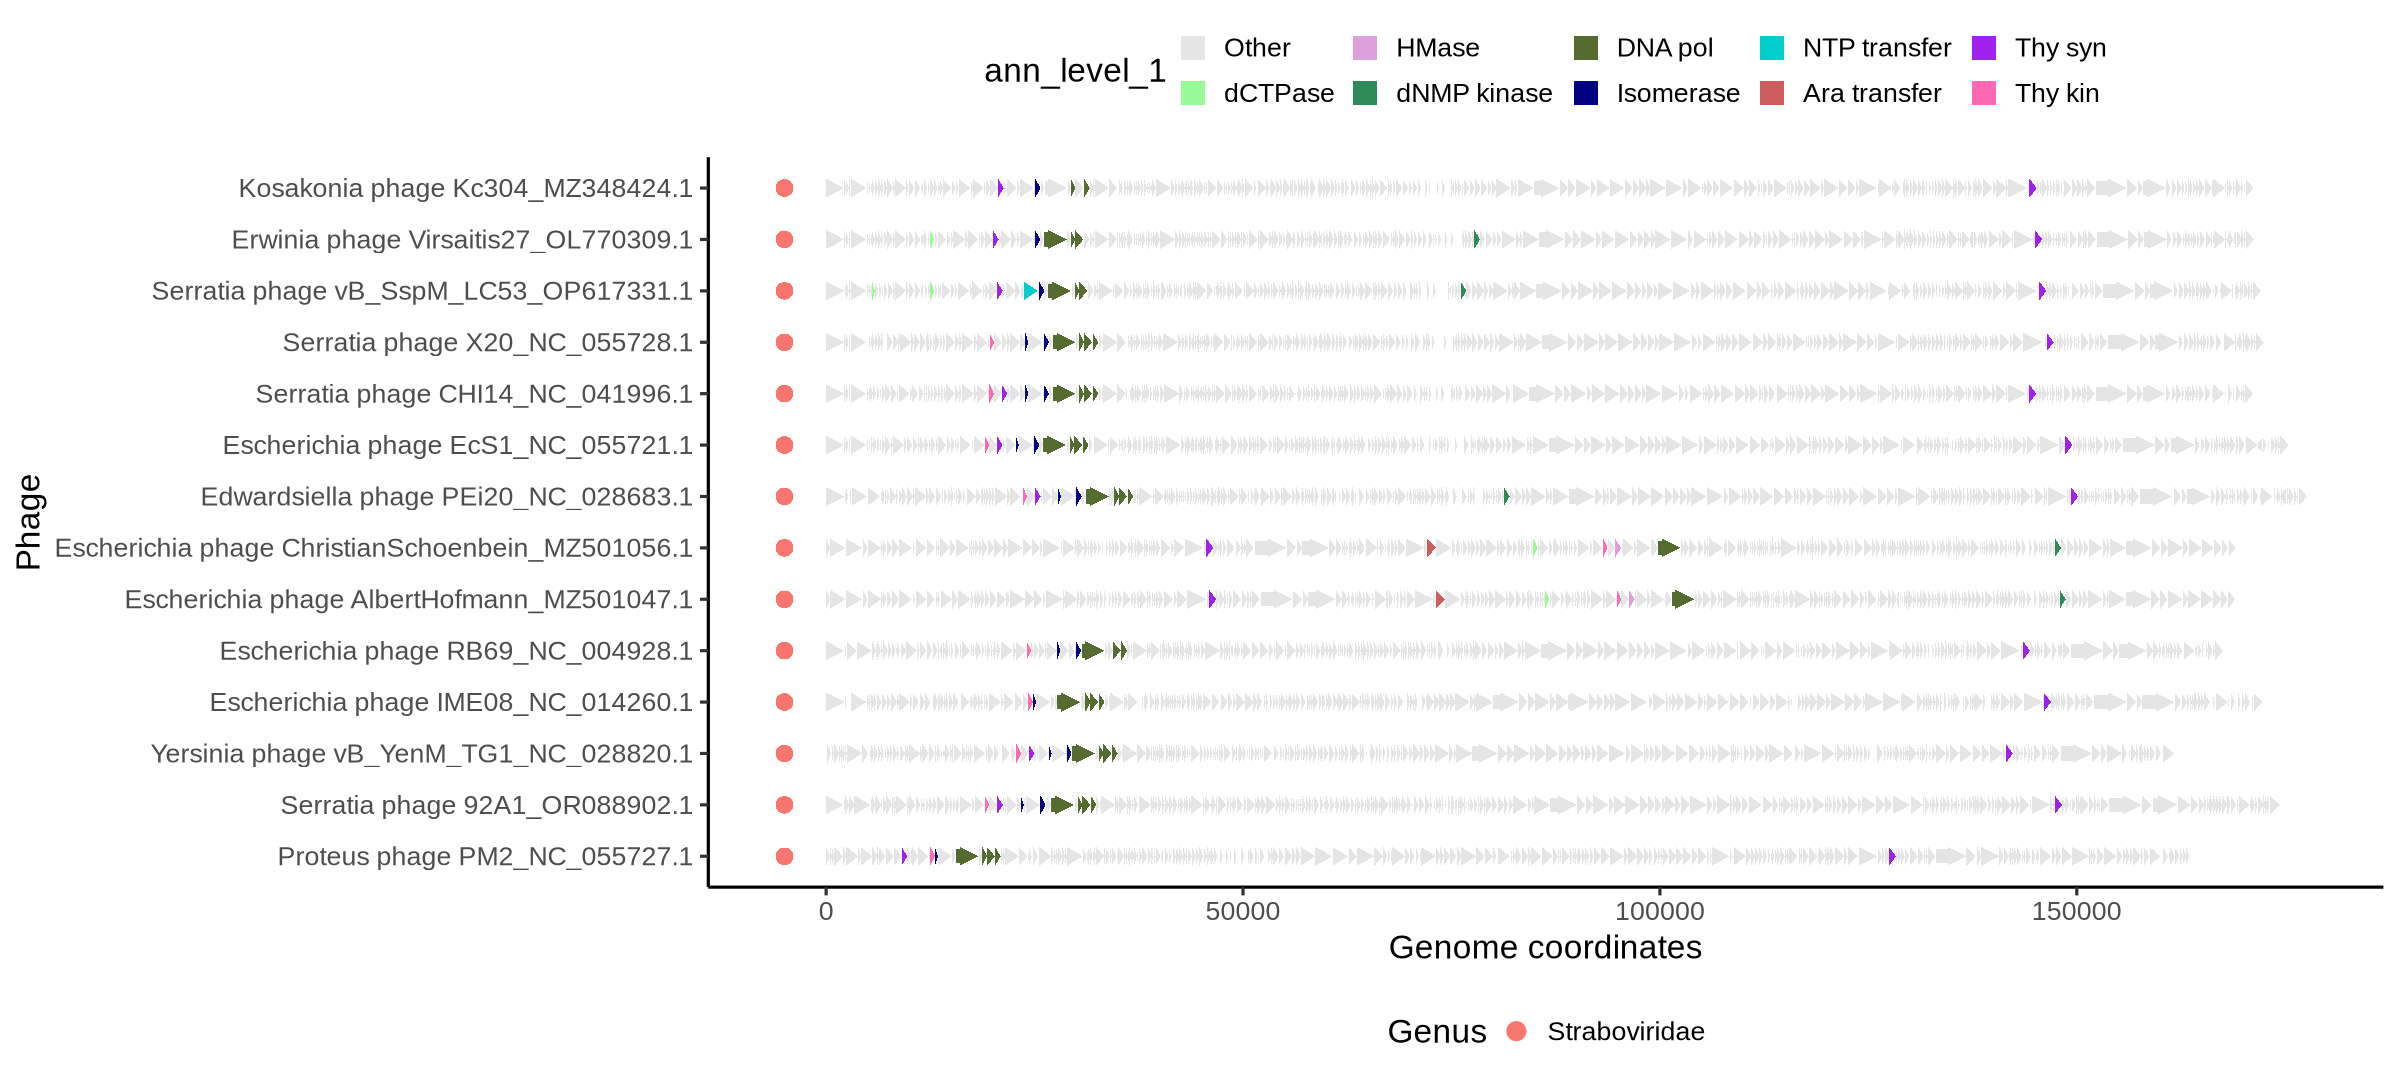

In [130]:
# LC53 arabinosylation cluster
options(repr.plot.width=20, repr.plot.height=9)

## Search phage names

## Select
genome_selection <- c(
    'Kosakonia phage Kc304','Erwinia phage Virsaitis27','Serratia phage vB_SspM_LC53','Serratia phage X20','Serratia phage CHI14',
    'Escherichia phage EcS1','Edwardsiella phage PEi20','Escherichia phage ChristianSchoenbein','Escherichia phage AlbertHofmann',
    'Escherichia phage RB69','Escherichia phage IME08','Yersinia phage vB_YenM_TG1','Serratia phage 92A1','Proteus phage PM2'
)

# Fetch data
df <- data
df$virusName <- factor(df$virusName, genome_selection)

## Subset
df <- df %>% subset(virusName %in% genome_selection)
df <- df[order(df$virusName, decreasing = TRUE), ]
df$phage_id <- factor(df$phage_id, unique(df$phage_id))

## Plot
ggplot(df, aes(xmin = gene_start, xmax = gene_stop, y = phage_id, fill = ann_level_1)) +
    geom_gene_arrow(col=NA) +
    scale_fill_manual(values = cols$ann_level_1) +
    geom_point(aes(x=-5000, col=Genus), size=4) +
    theme_classic(20) +
    guides(fill = guide_legend(override.aes = list(size=0, stroke=0), position = 'top', nrow = 2), 
           col = guide_legend(override.aes = list(size=5), position = 'bottom', nrow = 1)) +
    labs(x = "Genome coordinates", y = "Phage") +
    scale_x_continuous(limits = c(NA, NA))

Warning message:
“Removed 3022 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”
Warning message:
“Removed 3862 rows containing missing values or values outside the scale range
(`geom_point()`).”


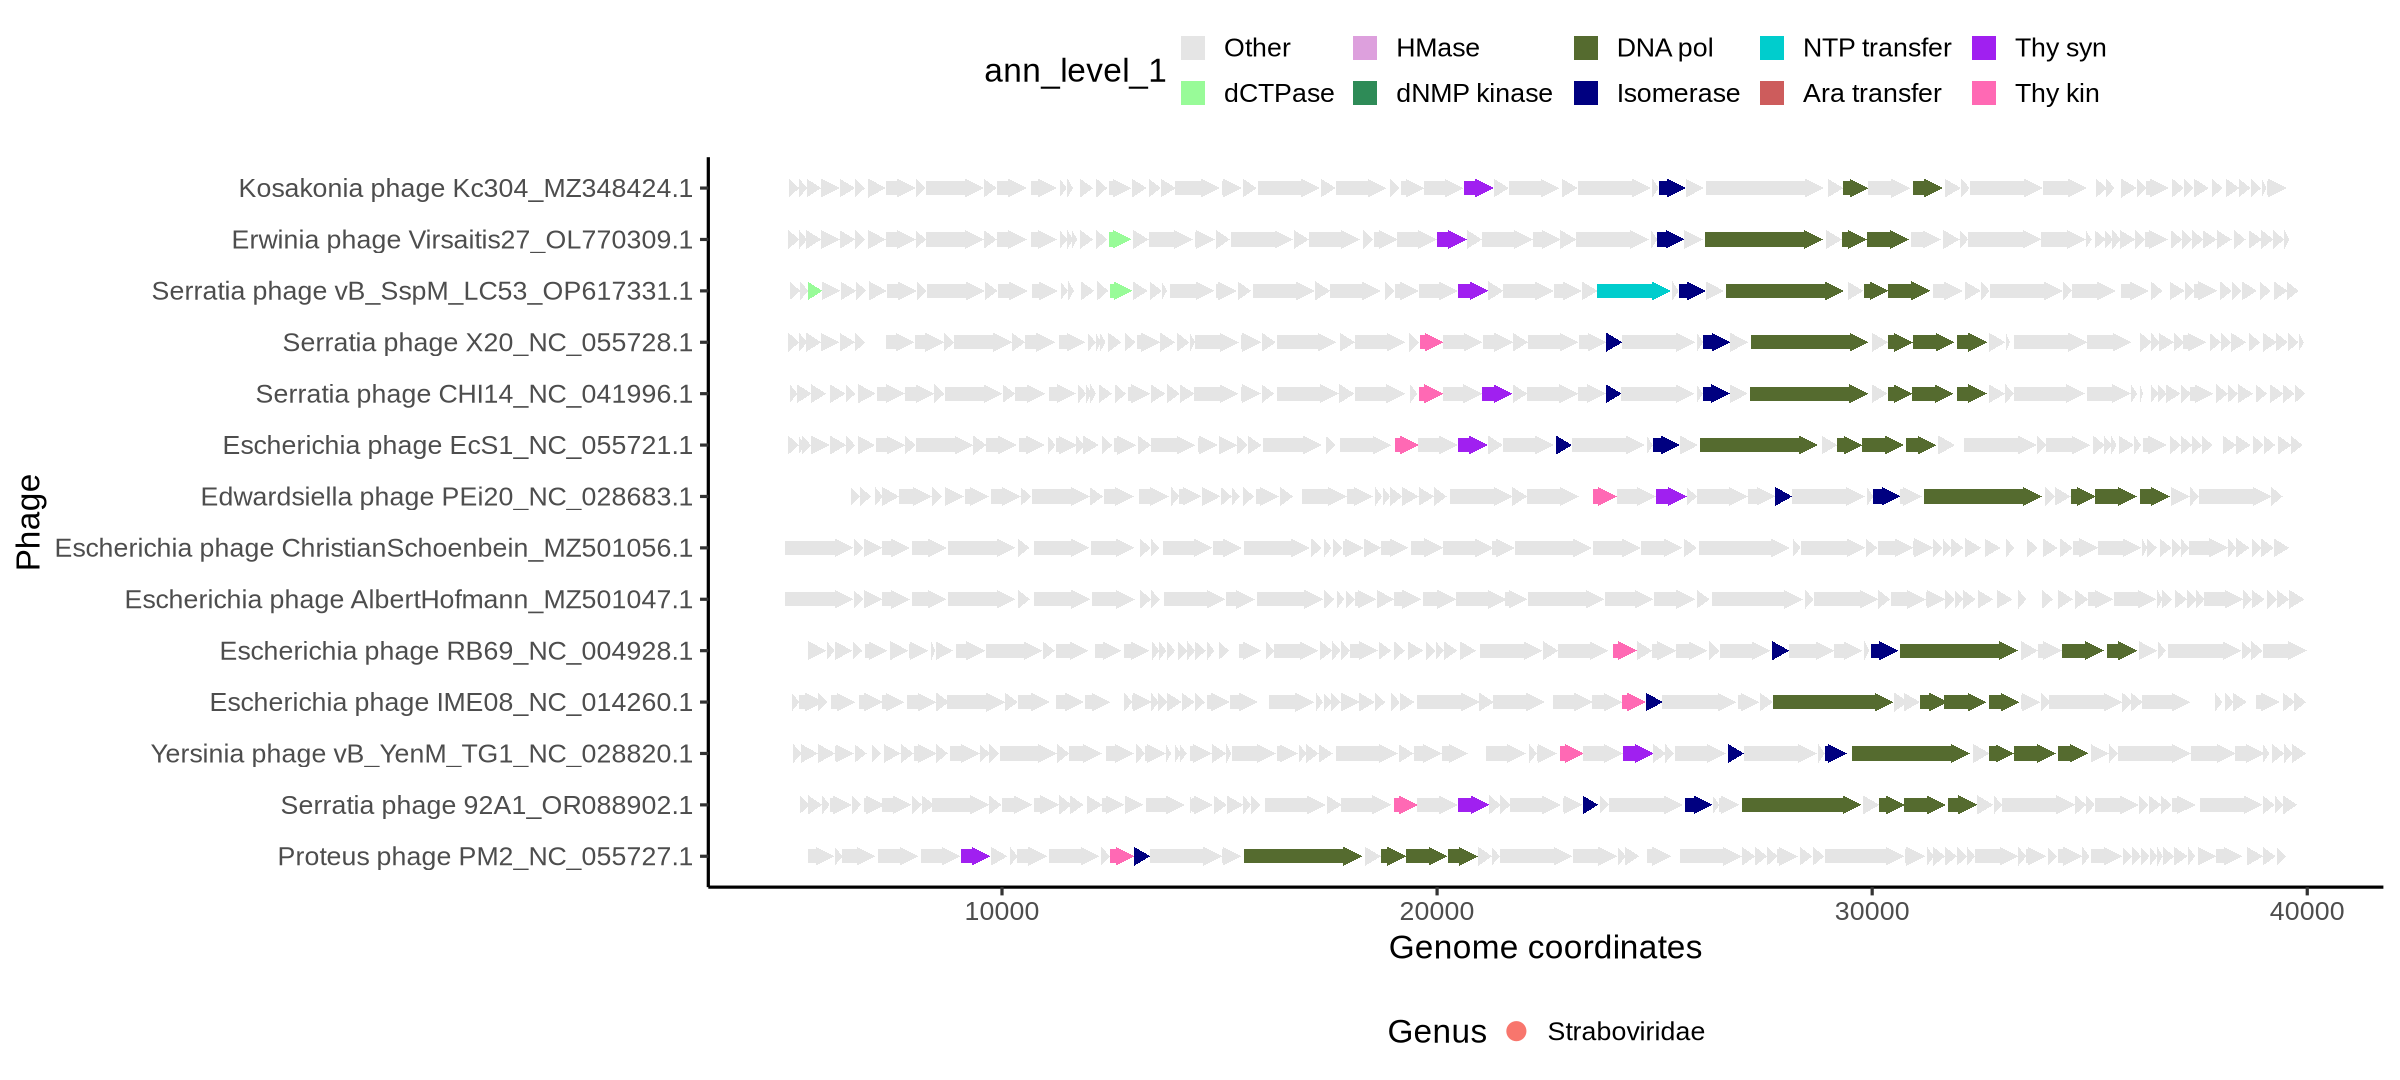

In [131]:
# LC53 arabinosylation cluster
options(repr.plot.width=20, repr.plot.height=9)

## Search phage names

## Select
genome_selection <- c(
    'Kosakonia phage Kc304','Erwinia phage Virsaitis27','Serratia phage vB_SspM_LC53','Serratia phage X20','Serratia phage CHI14',
    'Escherichia phage EcS1','Edwardsiella phage PEi20','Escherichia phage ChristianSchoenbein','Escherichia phage AlbertHofmann',
    'Escherichia phage RB69','Escherichia phage IME08','Yersinia phage vB_YenM_TG1','Serratia phage 92A1','Proteus phage PM2'
)

# Fetch data
df <- data
df$virusName <- factor(df$virusName, genome_selection)

## Subset
df <- df %>% subset(virusName %in% genome_selection)
df <- df[order(df$virusName, decreasing = TRUE), ]
df$phage_id <- factor(df$phage_id, unique(df$phage_id))

## Plot
ggplot(df, aes(xmin = gene_start, xmax = gene_stop, y = phage_id, fill = ann_level_1)) +
    geom_gene_arrow(col=NA) +
    scale_fill_manual(values = cols$ann_level_1) +
    geom_point(aes(x=-5000, col=Genus), size=4) +
    theme_classic(20) +
    guides(fill = guide_legend(override.aes = list(size=0, stroke=0), position = 'top', nrow = 2), 
           col = guide_legend(override.aes = list(size=5), position = 'bottom', nrow = 1)) +
    labs(x = "Genome coordinates", y = "Phage") +
    scale_x_continuous(limits = c(5000, 40000))

Warning message:
“Removed 3184 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”
Warning message:
“Removed 3862 rows containing missing values or values outside the scale range
(`geom_point()`).”


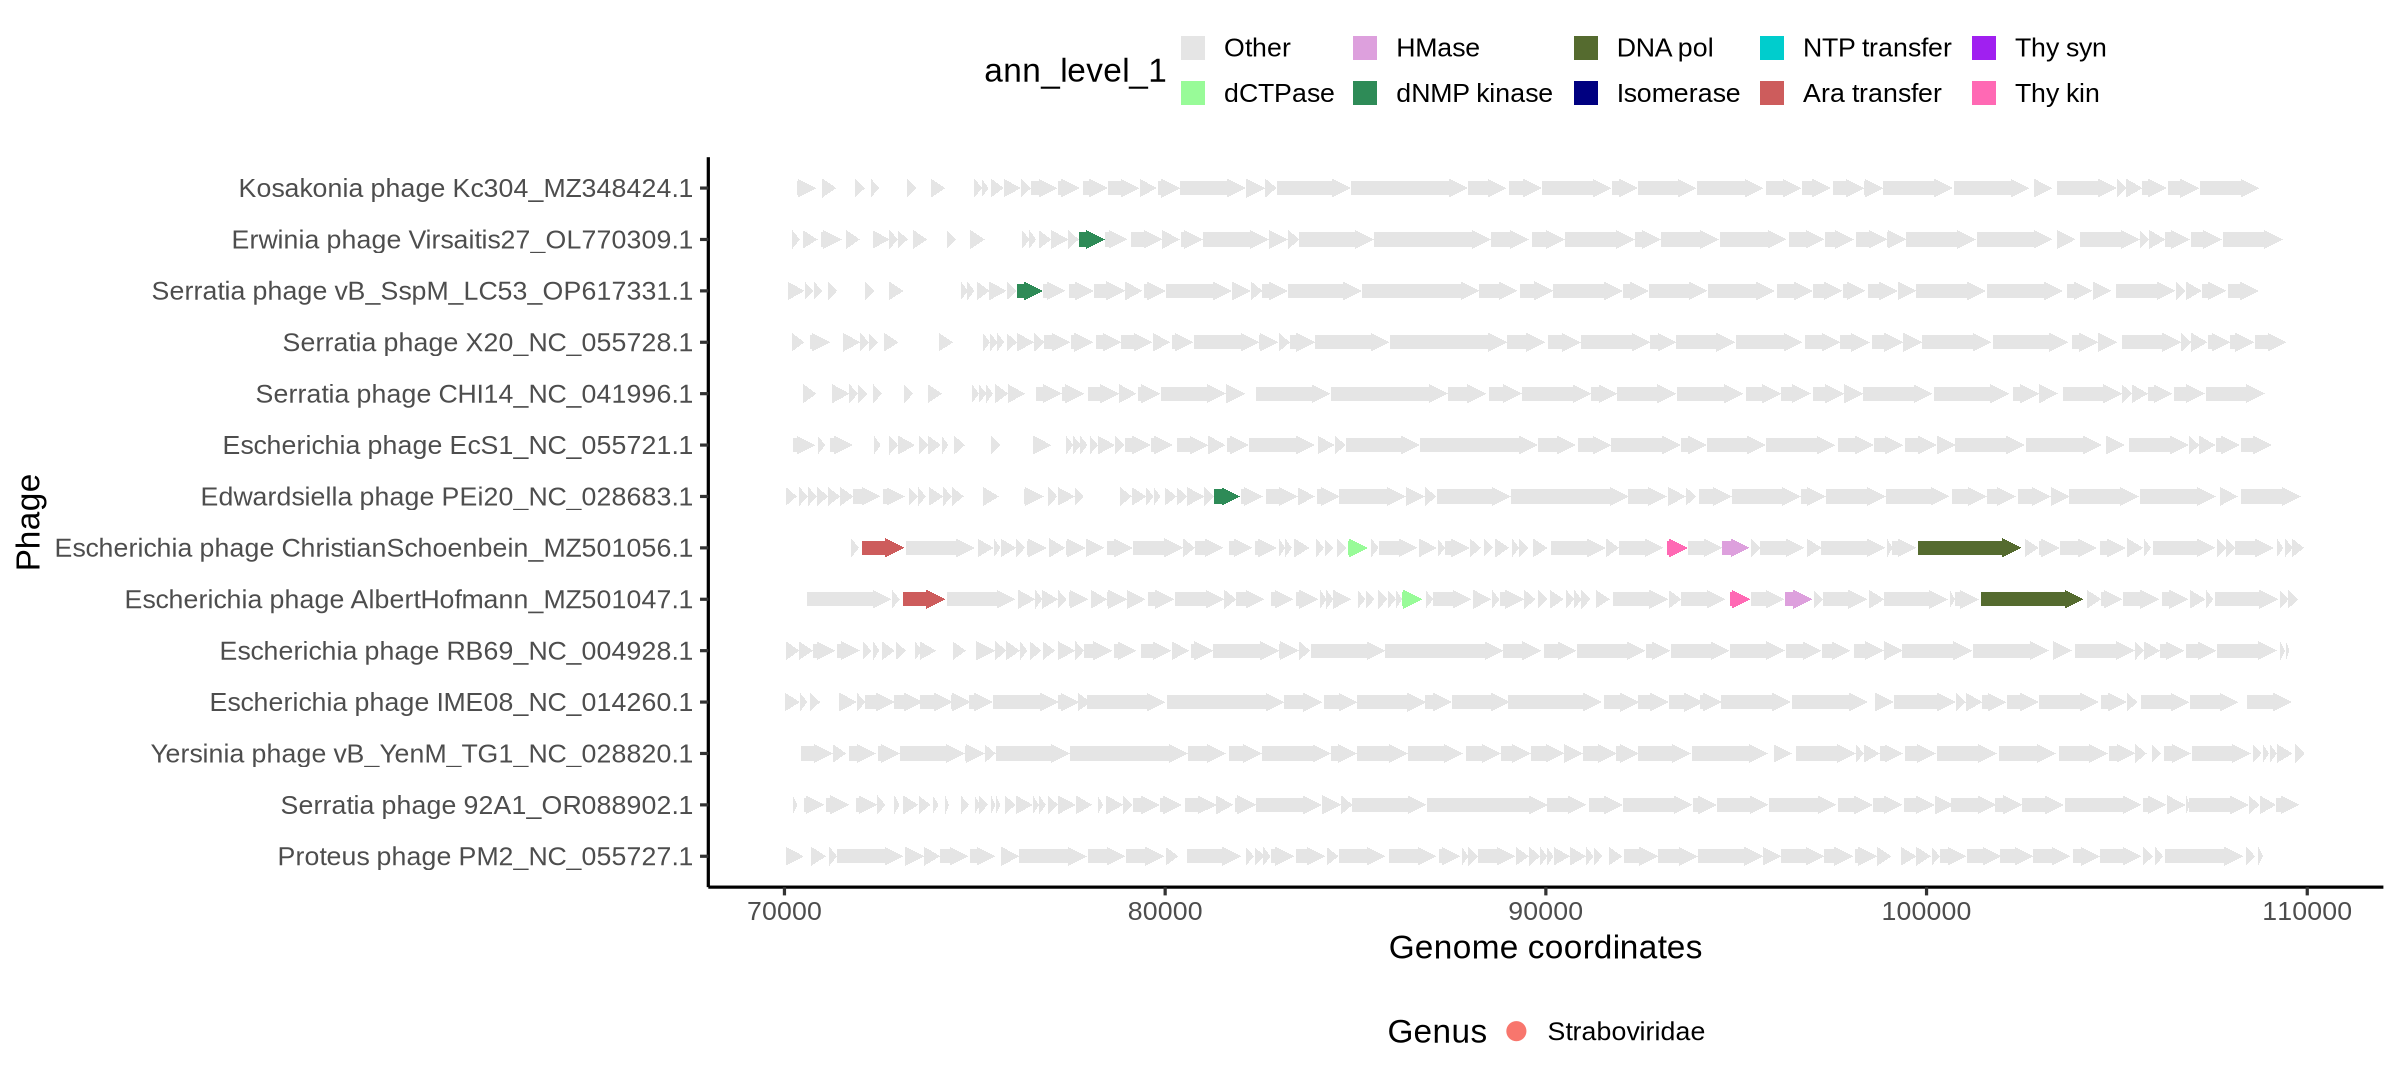

In [132]:
# LC53 arabinosylation cluster
options(repr.plot.width=20, repr.plot.height=9)

## Search phage names

## Select
genome_selection <- c(
    'Kosakonia phage Kc304','Erwinia phage Virsaitis27','Serratia phage vB_SspM_LC53','Serratia phage X20','Serratia phage CHI14',
    'Escherichia phage EcS1','Edwardsiella phage PEi20','Escherichia phage ChristianSchoenbein','Escherichia phage AlbertHofmann',
    'Escherichia phage RB69','Escherichia phage IME08','Yersinia phage vB_YenM_TG1','Serratia phage 92A1','Proteus phage PM2'
)

# Fetch data
df <- data
df$virusName <- factor(df$virusName, genome_selection)

## Subset
df <- df %>% subset(virusName %in% genome_selection)
df <- df[order(df$virusName, decreasing = TRUE), ]
df$phage_id <- factor(df$phage_id, unique(df$phage_id))

## Plot
ggplot(df, aes(xmin = gene_start, xmax = gene_stop, y = phage_id, fill = ann_level_1)) +
    geom_gene_arrow(col=NA) +
    scale_fill_manual(values = cols$ann_level_1) +
    geom_point(aes(x=-5000, col=Genus), size=4) +
    theme_classic(20) +
    guides(fill = guide_legend(override.aes = list(size=0, stroke=0), position = 'top', nrow = 2), 
           col = guide_legend(override.aes = list(size=5), position = 'bottom', nrow = 1)) +
    labs(x = "Genome coordinates", y = "Phage") +
    scale_x_continuous(limits = c(70000, 110000))

In [54]:
# Investigate genomes locations of inidividual phages
data %>% subset(virusName == 'Escherichia phage ChristianSchoenbein' & gene_start >= 92000 & gene_stop <= 100000)

Accession  Gene.CDS.Name                                         
1 MZ501056.1 putative thymidylate kinase                           
2 MZ501056.1 hypothetical protein                                  
3 MZ501056.1 dCMP hydroxymethylase                                 
4 MZ501056.1 hypothetical protein                                  
5 MZ501056.1 putative enzyme involved in UDP-arabinose biosynthesis
6 MZ501056.1 putative phosphatase                                  
7 MZ501056.1 putative enzyme involved in UDP-arabinose biosynthesis
8 MZ501056.1 hypothetical protein                                  
9 MZ501056.1 putative phosphosugar isomerase                       
  Gene.CDS.Nucleotide.FASTA.Title                                                                        
1 putative thymidylate kinase [organism=Escherichia phage ChristianSchoenbein]                           
2 hypothetical protein [organism=Escherichia phage ChristianSchoenbein]                                  
3 dCMP hydroxymethylase [organism=Escherichia phage ChristianSchoenbein]                                 
4 hypothetical protein [organism=Escherichia phage ChristianSchoenbein]                                  
5 putative enzyme involved in UDP-arabinose biosynthesis [organism=Escherichia phage ChristianSchoenbein]
6 putative phosphatase [organism=Escherichia phage ChristianSchoenbein]                                  
7 putative enzyme involved in UDP-arabinose biosynthesis [organism=Escherichia phage ChristianSchoenbein]
8 hypothetical protein [organism=Escherichia phage ChristianSchoenbein]                                  
9 putative phosphosugar isomerase [organism=Escherichia phage ChristianSchoenbein]                       
  Gene.CDS.Nucleotide.FASTA.Sequence.ID Gene.CDS.Nucleotide.FASTA.Range.Start
1 MZ501056.1:93189-93737                93189                                
2 MZ501056.1:93739-94638                93739                                
3 MZ501056.1:94638-95354                94638                                
4 MZ501056.1:95397-95636                95397                                
5 MZ501056.1:95633-96793                95633                                
6 MZ501056.1:96850-97251                96850                                
7 MZ501056.1:97236-98921                97236                                
8 MZ501056.1:98963-99106                98963                                
9 MZ501056.1:99103-99738                99103                                
  Gene.CDS.Nucleotide.FASTA.Range.Stop Gene.CDS.Protein.FASTA.Accession
1 93737                                QXV76984.1                      
2 94638                                QXV76985.1                      
3 95354                                QXV76986.1                      
4 95636                                QXV76987.1                      
5 96793                                QXV76988.1                      
6 97251                                QXV76989.1                      
7 98921                                QXV76990.1                      
8 99106                                QXV76991.1                      
9 99738                                QXV76992.1                      
  Gene.CDS.Protein.FASTA.Sequence.ID
1 QXV76984.1:1-182                  
2 QXV76985.1:1-299                  
3 QXV76986.1:1-238                  
4 QXV76987.1:1-79                   
5 QXV76988.1:1-386                  
6 QXV76989.1:1-133                  
7 QXV76990.1:1-561                  
8 QXV76991.1:1-47                   
9 QXV76992.1:1-211                  
  Gene.CDS.Protein.FASTA.Title                                                                           
1 putative thymidylate kinase [organism=Escherichia phage ChristianSchoenbein]                           
2 hypothetical protein [organism=Escherichia phage ChristianSchoenbein]                                  
3 dCMP hydroxymethylase [organism=Escherichia phage ChristianSchoenbein]  

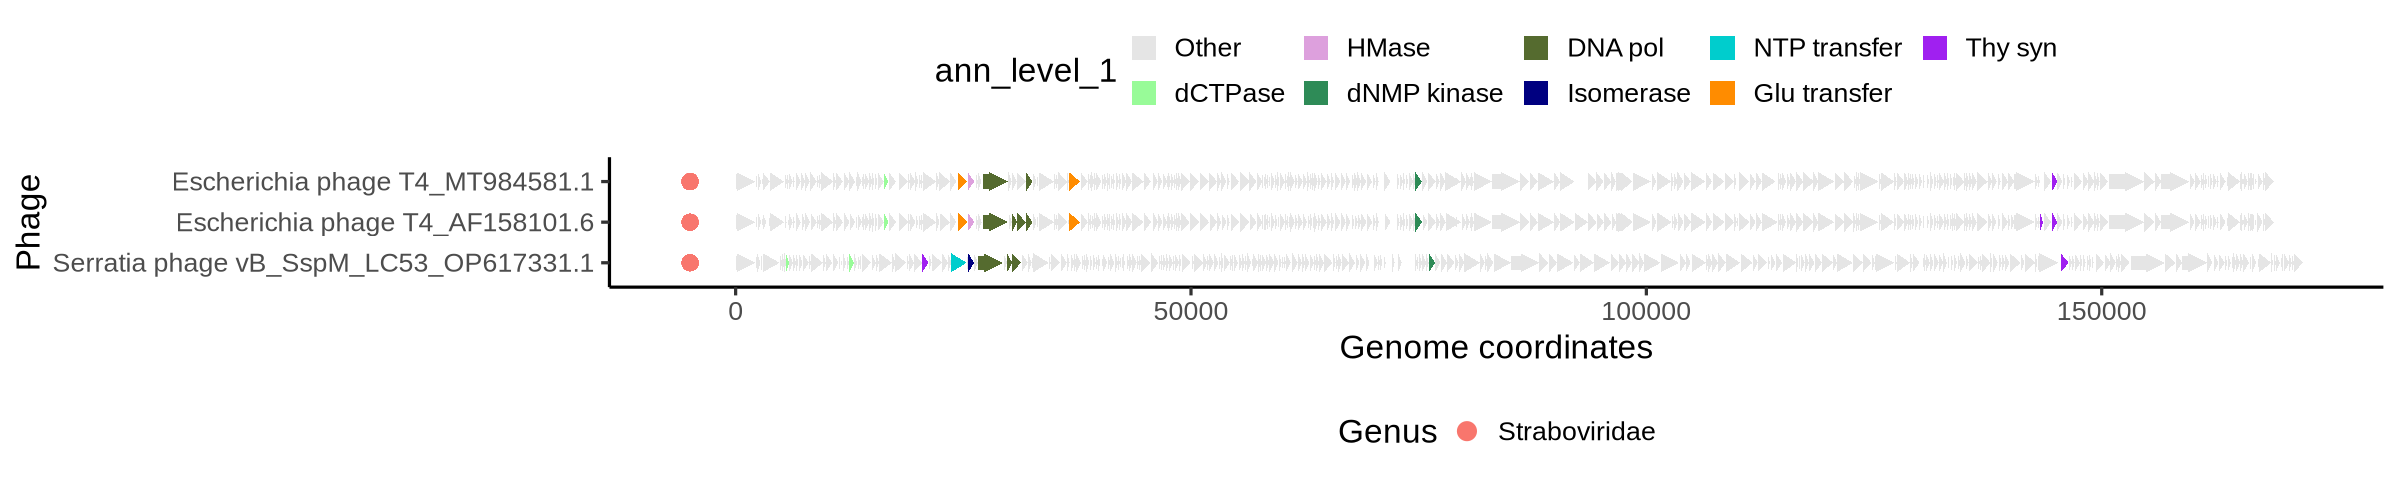

In [133]:
# LC53 arabinosylation cluster
options(repr.plot.width=20, repr.plot.height=4)

## Search phage names

## Select
genome_selection <- c(
    'Escherichia phage T4','Serratia phage vB_SspM_LC53'
)

# Fetch data
df <- data
df$virusName <- factor(df$virusName, genome_selection)

## Subset
df <- df %>% subset(virusName %in% genome_selection)
df <- df[order(df$virusName, decreasing = TRUE), ]
df$phage_id <- factor(df$phage_id, unique(df$phage_id))

## Plot
ggplot(df, aes(xmin = gene_start, xmax = gene_stop, y = phage_id, fill = ann_level_1)) +
    geom_gene_arrow(col=NA) +
    scale_fill_manual(values = cols$ann_level_1) +
    geom_point(aes(x=-5000, col=Genus), size=4) +
    theme_classic(20) +
    guides(fill = guide_legend(override.aes = list(size=0, stroke=0), position = 'top', nrow = 2), 
           col = guide_legend(override.aes = list(size=5), position = 'bottom', nrow = 1)) +
    labs(x = "Genome coordinates", y = "Phage") +
    scale_x_continuous(limits = c(NA, NA))

Warning message:
“Removed 693 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”
Warning message:
“Removed 835 rows containing missing values or values outside the scale range
(`geom_point()`).”


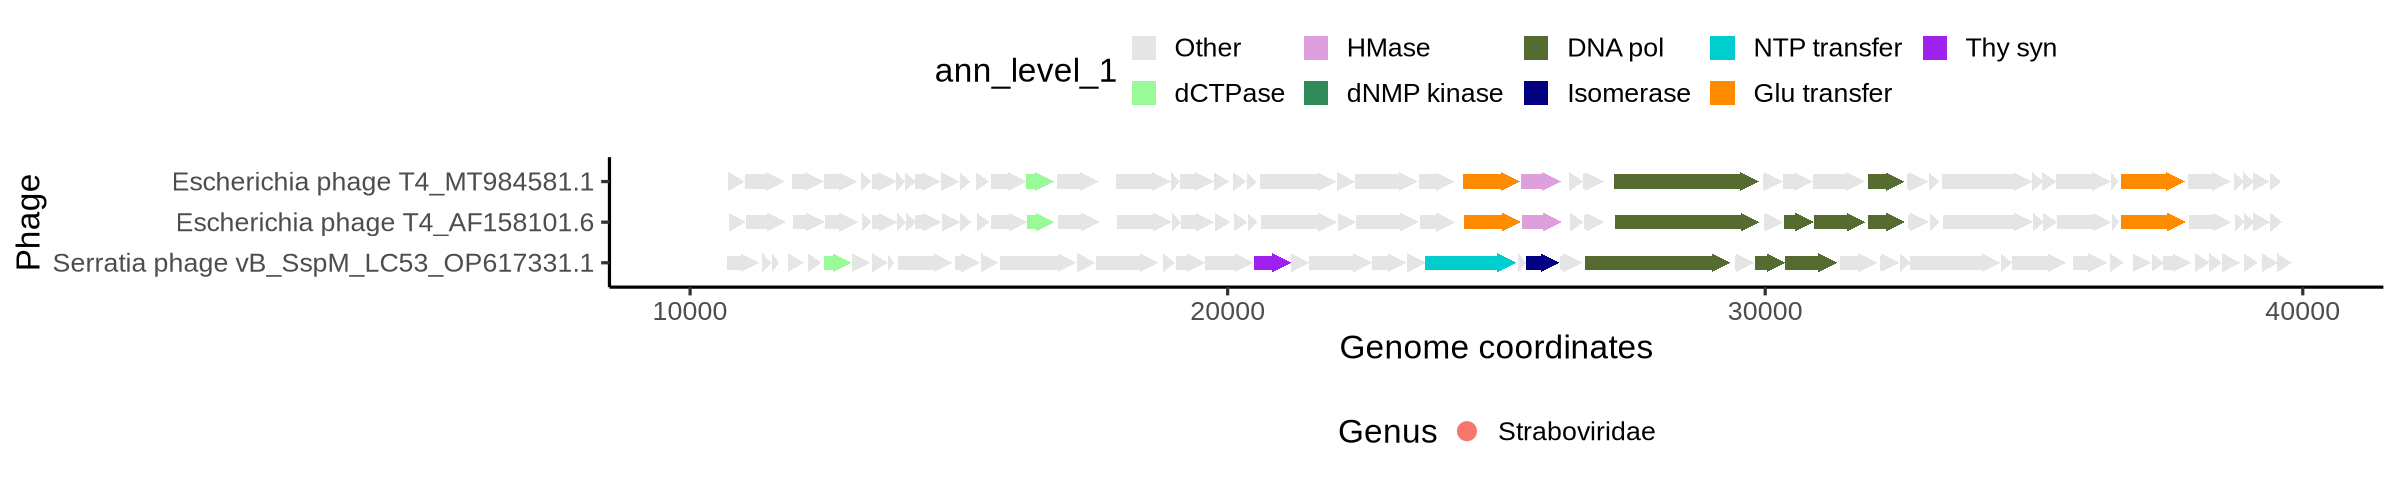

In [136]:
# LC53 arabinosylation cluster
options(repr.plot.width=20, repr.plot.height=4)

## Search phage names

## Select
genome_selection <- c(
    'Escherichia phage T4','Serratia phage vB_SspM_LC53'
)

# Fetch data
df <- data
df$virusName <- factor(df$virusName, genome_selection)

## Subset
df <- df %>% subset(virusName %in% genome_selection)
df <- df[order(df$virusName, decreasing = TRUE), ]
df$phage_id <- factor(df$phage_id, unique(df$phage_id))

## Plot
ggplot(df, aes(xmin = gene_start, xmax = gene_stop, y = phage_id, fill = ann_level_1)) +
    geom_gene_arrow(col=NA) +
    scale_fill_manual(values = cols$ann_level_1) +
    geom_point(aes(x=-5000, col=Genus), size=4) +
    theme_classic(20) +
    guides(fill = guide_legend(override.aes = list(size=0, stroke=0), position = 'top', nrow = 2), 
           col = guide_legend(override.aes = list(size=5), position = 'bottom', nrow = 1)) +
    labs(x = "Genome coordinates", y = "Phage") +
    scale_x_continuous(limits = c(10000, 40000))

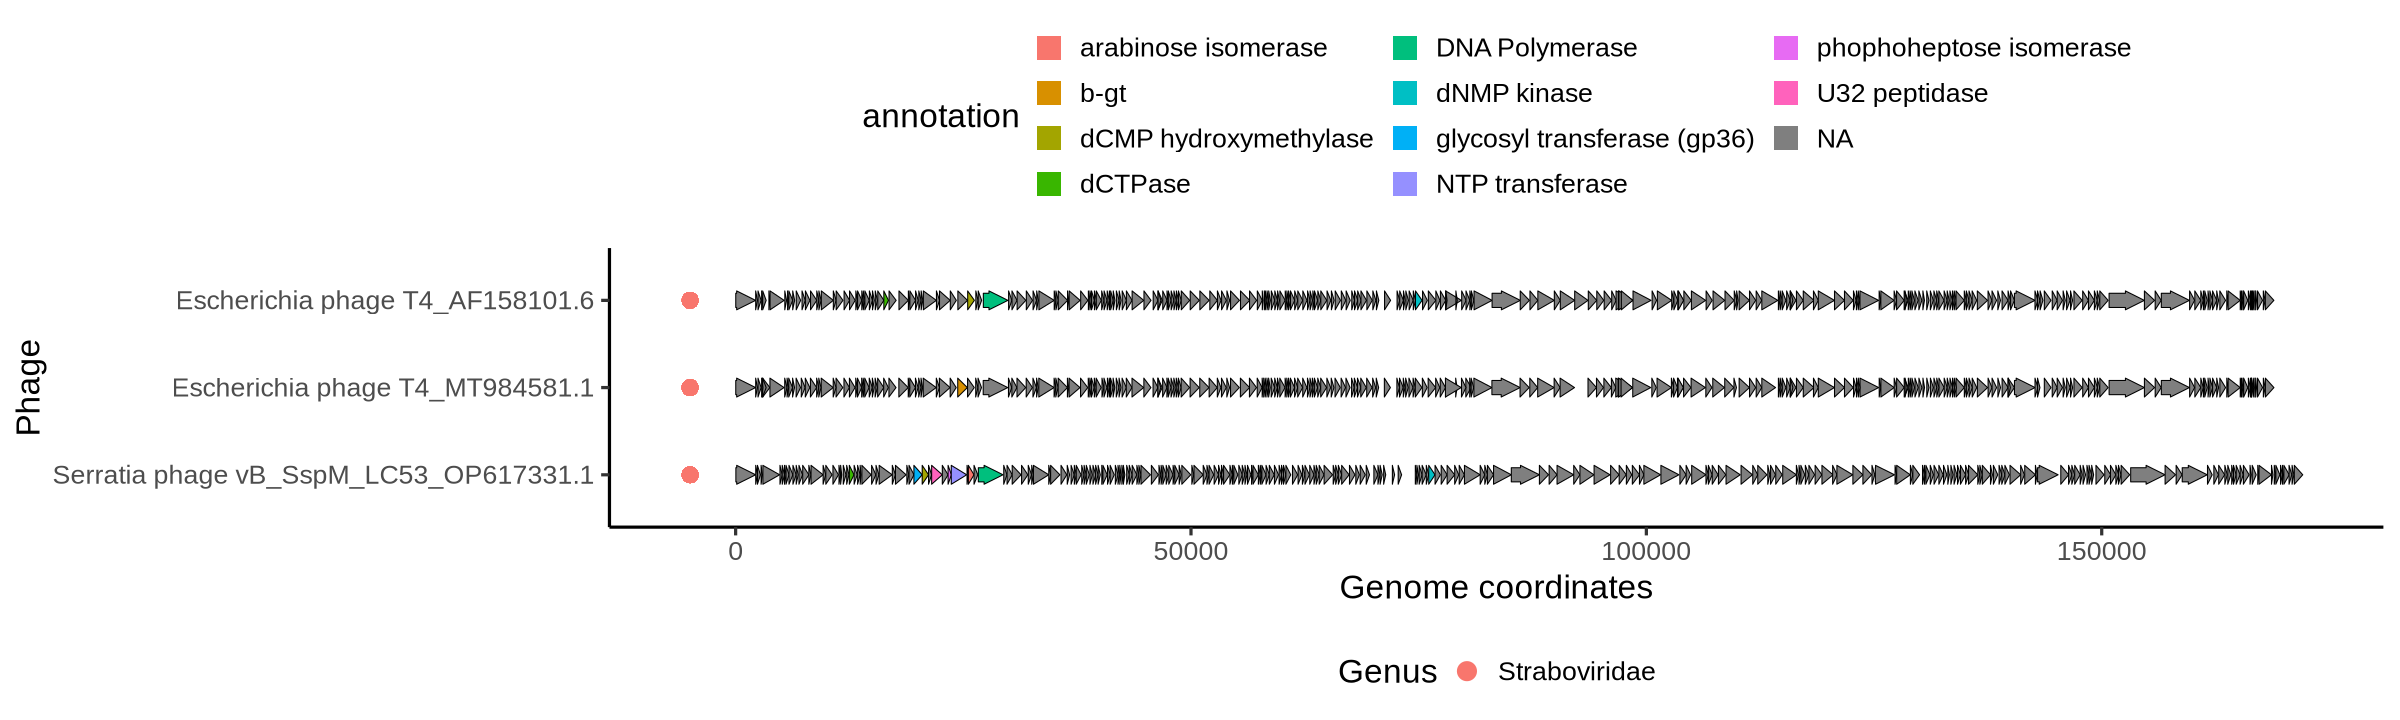

In [116]:
# Comparison of T4 and LC54
options(repr.plot.width=20, repr.plot.height=6)

# Fetch data
df <- data
df <- df[order(df$Genus, df$genomeSize, decreasing = c(TRUE, TRUE)), ]
df$phage_id <- factor(df$phage_id, unique(df$phage_id))

# Mutate
df <- df %>% group_by(phage_id) %>% mutate(total=max(gene_stop, na.rm = TRUE), ratio_start=gene_start/total, ratio_stop=gene_stop/total)

## Subset
df <- df %>% subset(virusName %in% c("Escherichia phage T4","Serratia phage vB_SspM_LC53"))

## Plot
ggplot(df, aes(xmin = gene_start, xmax = gene_stop, y = phage_id, fill = annotation)) +
    geom_gene_arrow() +
    geom_point(aes(x=-5000, col=Genus), size=4) +
    theme_classic(20) +
    guides(fill = guide_legend(override.aes = list(size=0, stroke=0), position = 'top', nrow = 4), 
           col = guide_legend(override.aes = list(size=5), position = 'bottom', nrow = 1)) +
    labs(x = "Genome coordinates", y = "Phage")

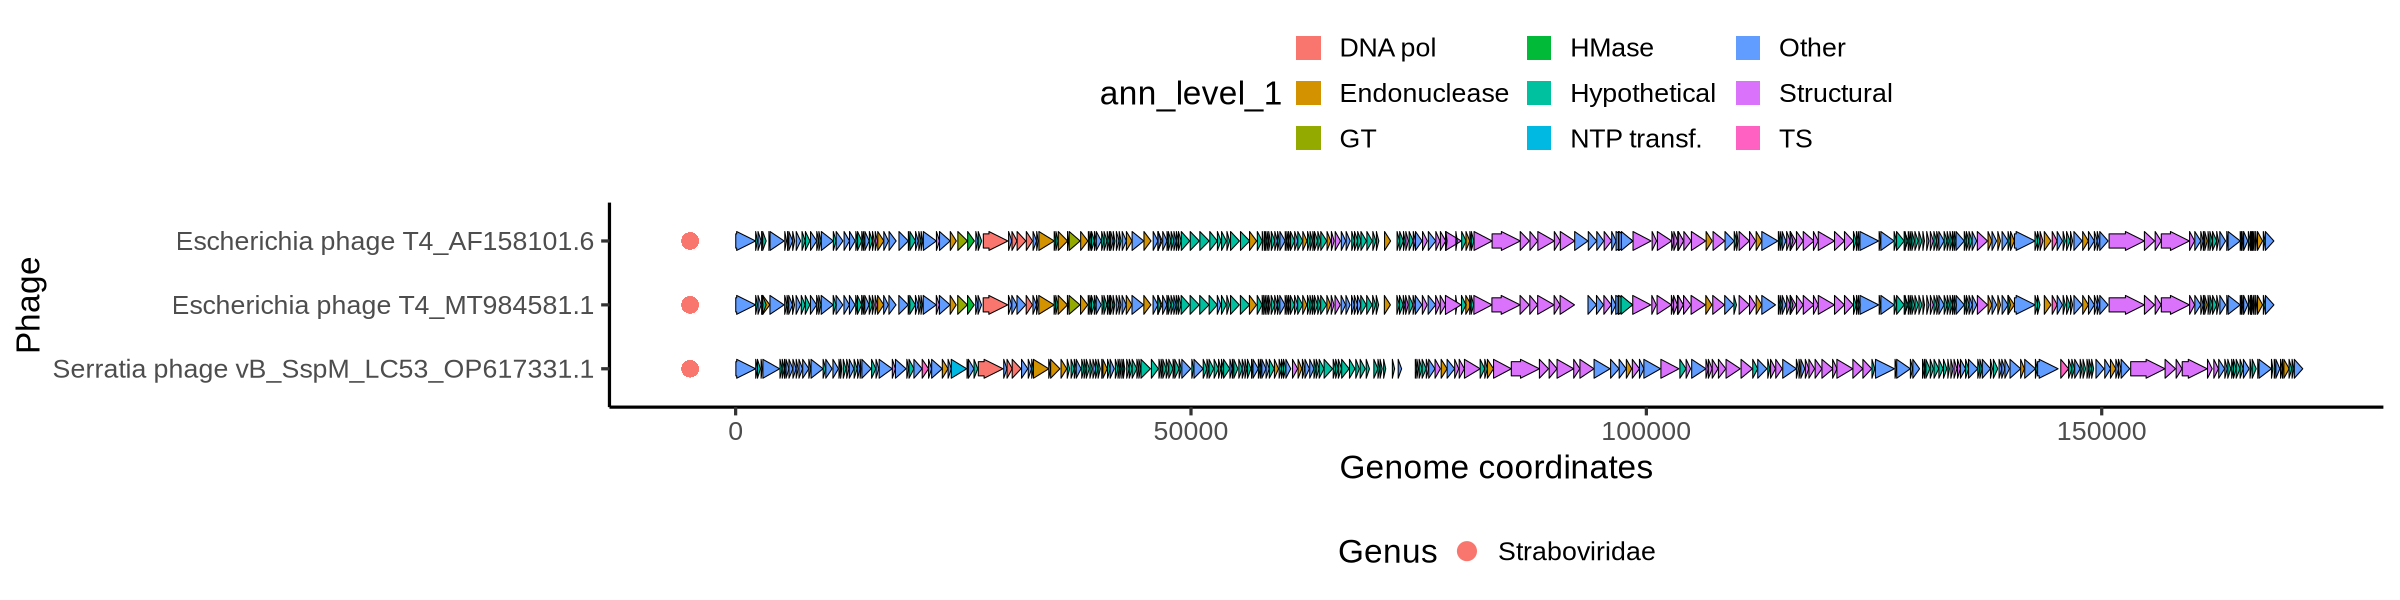

In [119]:
options(repr.plot.width=20, repr.plot.height=5)

## Plot
ggplot(df, aes(xmin = gene_start, xmax = gene_stop, y = phage_id, fill = ann_level_1)) +
    geom_gene_arrow() +
    geom_point(aes(x=-5000, col=Genus), size=4) +
    theme_classic(20) +
    guides(fill = guide_legend(override.aes = list(size=0, stroke=0), position = 'top', nrow = 3), 
           col = guide_legend(override.aes = list(size=5), position = 'bottom', nrow = 1)) +
    labs(x = "Genome coordinates", y = "Phage")

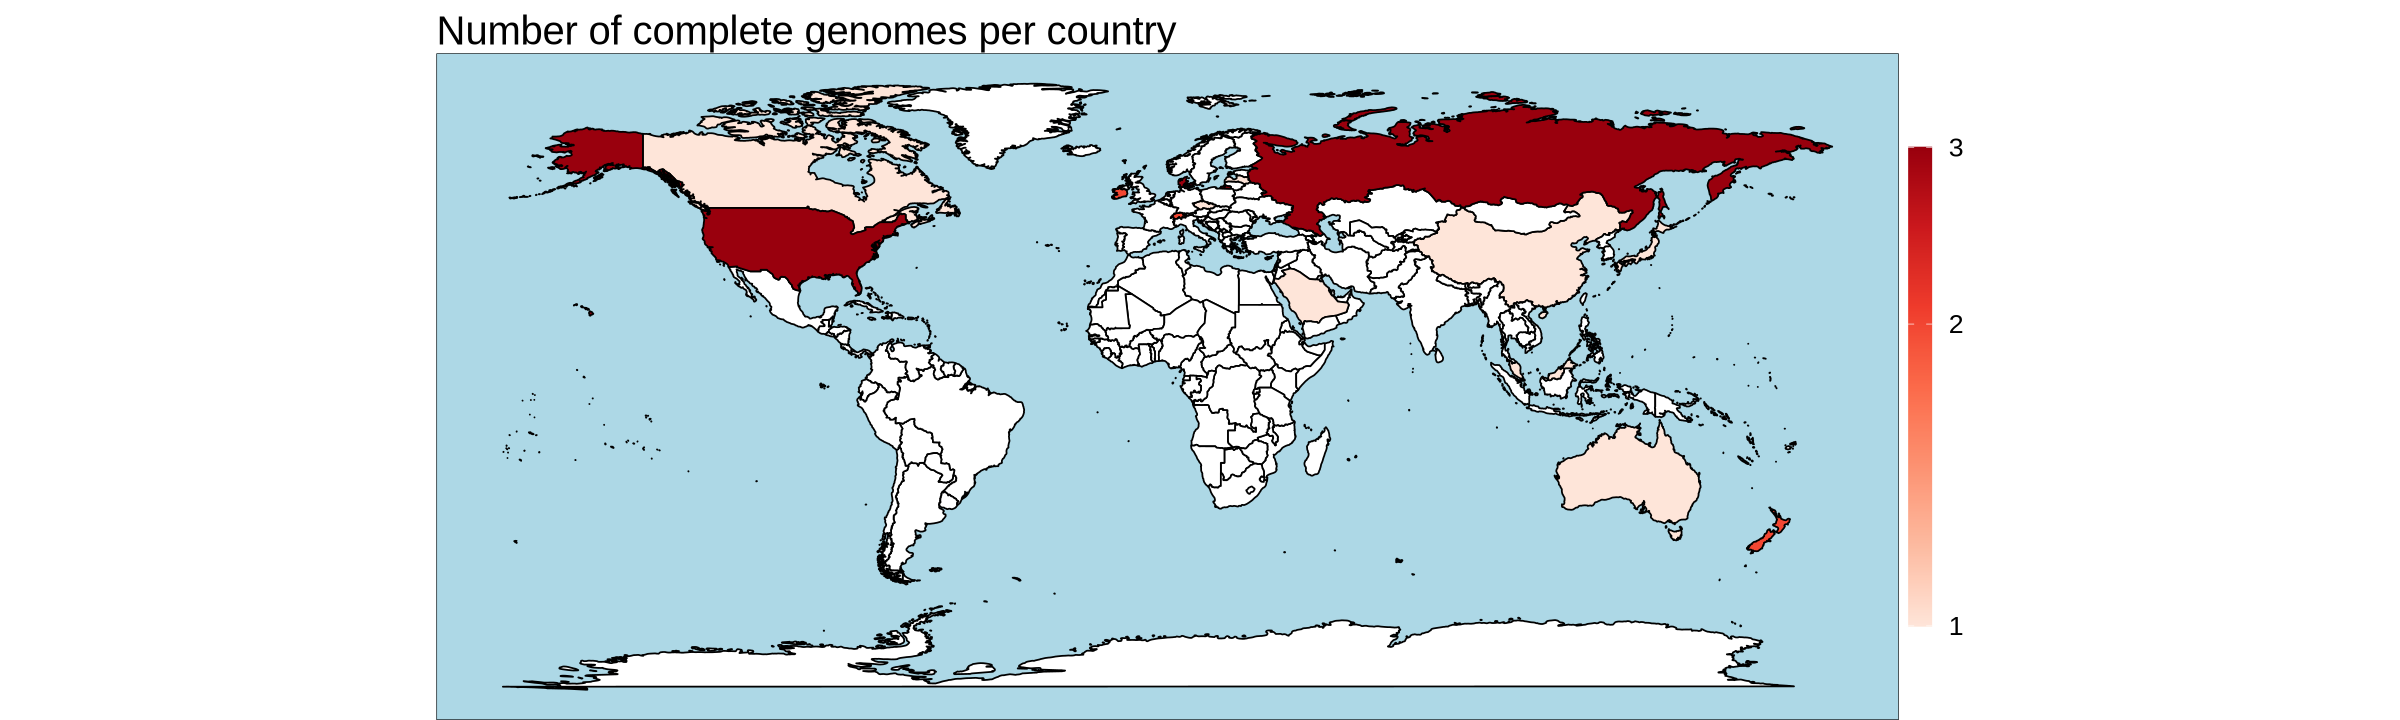

In [15]:
## Show phageCount on world map
options(repr.plot.width=20, repr.plot.height=6)

# Fetch data
world_map = map_data("world")

## Edit geoLocation
report$geoCountry <- str_split(report$geoLocation, ":", simplify=TRUE)[,1]

# Add phageCount
lv <- setNames(as.numeric(table(report$geoCountry)), names(table(report$geoCountry)))
world_map$phageCount <- lv[world_map$region]

# Plot
ggplot(world_map, aes(map_id = region, fill=phageCount)) +
    geom_map(map = world_map, col="black") +
    scale_fill_distiller(palette = "Reds", direction = 1, trans="log10", na.value = "white") +
    expand_limits(x = world_map$long, y = world_map$lat) +
    theme_void(20) +
    theme(
        panel.background = element_rect(fill = "lightblue")
    ) +
    guides(
        fill = guide_colorbar(barheight=20, barwidth=1)
    ) +
    coord_fixed() +
    labs(title="Number of complete genomes per country", fill=NULL)

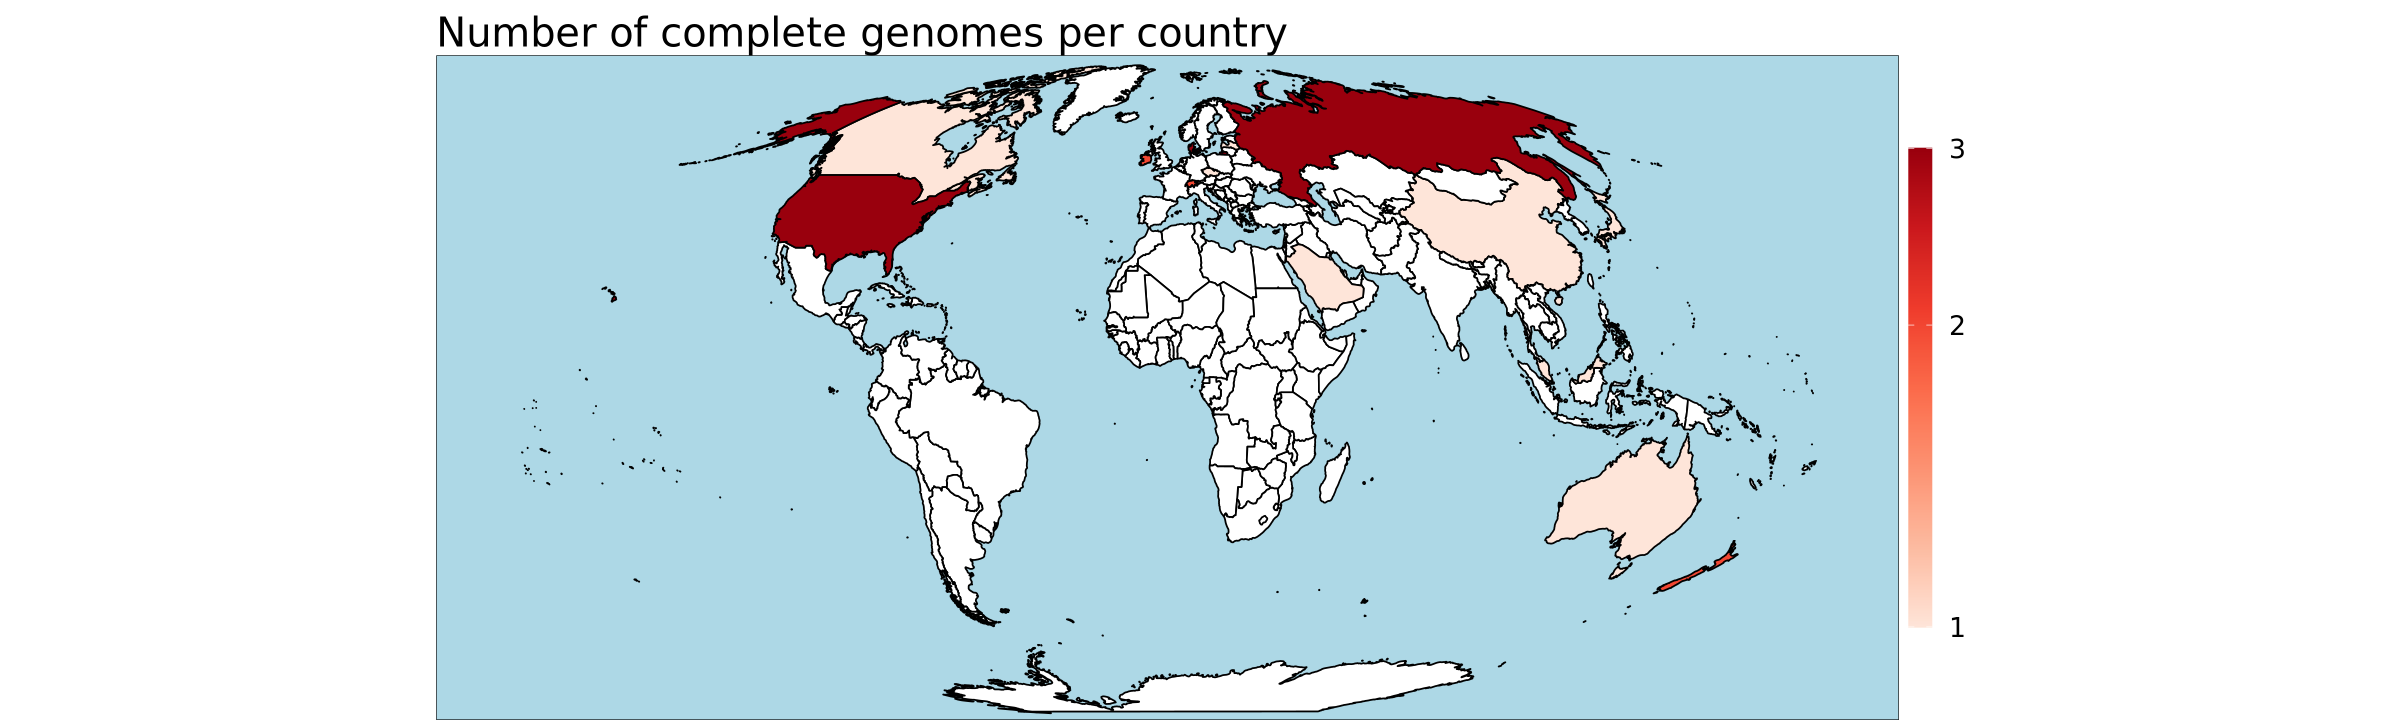

In [14]:
## Preserve area
options(repr.plot.width=20, repr.plot.height=6)

# Fix projection anomalies
world_map <- world_map %>% 
  filter(! long > 180)

# Plot
ggplot(world_map, aes(map_id = region, fill=phageCount)) +
    geom_map(map = world_map, col="black") +
    scale_fill_distiller(palette = "Reds", direction = 1, trans="log10", na.value = "white") +
    expand_limits(x = world_map$long, y = world_map$lat) +
    theme_void(20) +
    theme(
        panel.background = element_rect(fill = "lightblue")
    ) +
    guides(
        fill = guide_colorbar(barheight=20, barwidth=1)
    ) +
    coord_map("moll") +
    labs(title="Number of complete genomes per country", fill=NULL)

In [15]:
## Save modified report
write.csv(report, genomes$overview)

In [16]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 9.2 (Blue Onyx)

Matrix products: default
BLAS/LAPACK: /home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Pacific/Auckland
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] maps_3.4.2.1        spData_2.3.3        sf_1.0-19          
 [4] gggenes_0.5.1       viridis_0.6.5       viridisLite_0.4.2  
 [7] ggplot2_3.5.1       jsonlite_1.8.9      